## Data Augmentation and Processing Notebook 

### Key attributes needs for analysis are Zestimate, price per square ft and rentZestimate

We are using Georgia (GA) Listing data to get all the addresses of properties which are on interest. We then use following sources to augment that data:
* Zillow
* IRS (Tax data)
* FHFA (HPI data)

The data is then further transformed by feature extraction or feature engineeting work, for example:
* Schools (from Zillow)
* Lot Size (from Zillow and GA Listings)

### Importing Key Libraries

In [1]:
from googlesearch import search # get zpid
import pandas as pd
import numpy as np
import requests
import json
import time
import io
import plotly.express as px

# show all columns
pd.set_option('display.max_columns', None)

### <font color='red'> We start with full zillow data load and select only a few columns

In [2]:
df_prop_detail = pd.read_csv('full_output original copy.csv')

/var/folders/jr/_gd99zyd2gg8ks3xkxshk6240000gn/T/ipykernel_72664/1348069022.py:1: DtypeWarning: Columns (129,150,159,172,185,205,282,283) have mixed types. Specify dtype option on import or set low_memory=False.
  df_prop_detail = pd.read_csv('full_output original copy.csv')


In [3]:
df_prop_detail.shape

(5145, 284)

In [4]:
df_scrape = df_prop_detail[['zpid', 'propertyTaxRate', 'rentZestimate', 'zestimate',
       'resoFacts.pricePerSquareFoot', 'propertyTypeDimension', 'livingArea',
       'bathrooms', 'bedrooms', 'annualHomeownersInsurance', 'monthlyHoaFee',
       'resoFacts.taxAnnualAmount', 'yearBuilt', 'dateSold', 'price', 'pageViewCount',
       'description', 'homeStatus', 'favoriteCount', 'schools',
       'streetAddress', 'zipcode', 'city', 'resoFacts.hasAttachedProperty',
       'resoFacts.poolFeatures', 'resoFacts.flooring', 'resoFacts.hasGarage', 'resoFacts.parking',
       'resoFacts.hasWaterfrontView',
       'resoFacts.lotSize', 'resoFacts.architecturalStyle', 'resoFacts.structureType', 'resoFacts.appliances',
       'resoFacts.communityFeatures', 'resoFacts.propertyCondition', 'resoFacts.utilities', 'url']]

In [5]:
df_scrape.columns = df_scrape.columns.str.replace('resoFacts.', '')

/var/folders/jr/_gd99zyd2gg8ks3xkxshk6240000gn/T/ipykernel_72664/2492488022.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df_scrape.columns = df_scrape.columns.str.replace('resoFacts.', '')


In [6]:
df_scrape.columns

Index(['zpid', 'propertyTaxRate', 'rentZestimate', 'zestimate',
       'pricePerSquareFoot', 'propertyTypeDimension', 'livingArea',
       'bathrooms', 'bedrooms', 'annualHomeownersInsurance', 'monthlyHoaFee',
       'taxAnnualAmount', 'yearBuilt', 'dateSold', 'price', 'pageViewCount',
       'description', 'homeStatus', 'favoriteCount', 'schools',
       'streetAddress', 'zipcode', 'city', 'hasAttachedProperty',
       'poolFeatures', 'flooring', 'hasGarage', 'parking', 'hasWaterfrontView',
       'lotSize', 'architecturalStyle', 'structureType', 'appliances',
       'communityFeatures', 'propertyCondition', 'utilities', 'url'],
      dtype='object')

In [7]:
df_upload = pd.read_csv('short_lookup.csv')

In [8]:
with open("zpid_list", "r") as fp:
     zpid_list = json.load(fp)

In [9]:
# join original dataset to property details
# create new column for zpid
df_upload['zpid'] = zpid_list

In [10]:
df_scrape.shape

(5145, 37)

In [11]:
df_upload.shape

(5146, 5)

In [12]:
df_upload.head()

,address,city,state,zip,zpid
0,101 College Street,Kingsland,Georgia,31548,2064281489
1,169 School House Creek Drive,Saint Marys,Georgia,31558,91030716
2,1621 Sandpiper Court,Saint Marys,Georgia,31558,111242225
3,346 Laurel Landing Boulevard,Kingsland,Georgia,31548,2090936200
4,81 Ossabaw Way,Waverly,Georgia,31565,2064330080


In [13]:
df_upload['zpid'].isna().sum()

110

In [14]:
df_scrape['zpid'].isna().sum()

114

In [15]:
df_scrape.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5145 entries, 0 to 5144
Data columns (total 37 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   zpid                       5031 non-null   float64
 1   propertyTaxRate            5031 non-null   float64
 2   rentZestimate              4325 non-null   float64
 3   zestimate                  3972 non-null   float64
 4   pricePerSquareFoot         4519 non-null   float64
 5   propertyTypeDimension      5031 non-null   object 
 6   livingArea                 4850 non-null   float64
 7   bathrooms                  4866 non-null   float64
 8   bedrooms                   4822 non-null   float64
 9   annualHomeownersInsurance  5031 non-null   float64
 10  monthlyHoaFee              1863 non-null   float64
 11  taxAnnualAmount            4385 non-null   float64
 12  yearBuilt                  4845 non-null   float64
 13  dateSold                   4363 non-null   objec

<font color = red> We can delete the records that did not give us a match from zillow 

In [16]:
df_scrape = df_scrape[~df_scrape['zpid'].isna()]

In [17]:
df_scrape.shape

(5031, 37)

In [18]:
print(df_upload['zpid'].dtype)
print(df_scrape['zpid'].dtype)

object
float64


In [19]:
df_upload['zpid'] = df_upload['zpid'].astype(float)

In [20]:
len(df_upload.zpid.unique())

4612

### <font color='blue'> This section combines original data with zillow provided data
<font color='green'> The df_upload_unique is simply the unique addresses that we loaded before pulling data from Zillow API. The idea is to merge unique addresses with zillow  data
The output of this process is "df_join" data frame, the idea being we have the relevant zillow information with zpid and original addresses that we used to request zillow data 

In [21]:
df_upload_unique = df_upload.drop_duplicates(subset=['zpid'], keep='first')

In [22]:
len(df_scrape.zpid.unique())

4608

#### <font color=blue> There are dupicate properties in the Georgia Listing data, we will keep first hit from Zillow

In [23]:
df_scrape_unique = df_scrape.drop_duplicates(subset=['zpid'], keep='first')

In [24]:
df_scrape_unique.shape

(4608, 37)

In [25]:
df_upload_unique.shape

(4612, 5)

In [26]:
df_join = pd.merge(df_upload_unique, df_scrape_unique, how='left', on='zpid')
print('Num of columns:', len(df_join.columns))
df_join.head()

Num of columns: 41


,address,city_x,state,zip,zpid,propertyTaxRate,rentZestimate,zestimate,pricePerSquareFoot,propertyTypeDimension,livingArea,bathrooms,bedrooms,annualHomeownersInsurance,monthlyHoaFee,taxAnnualAmount,yearBuilt,dateSold,price,pageViewCount,description,homeStatus,favoriteCount,schools,streetAddress,zipcode,city_y,hasAttachedProperty,poolFeatures,flooring,hasGarage,parking,hasWaterfrontView,lotSize,architecturalStyle,structureType,appliances,communityFeatures,propertyCondition,utilities,url
0,101 College Street,Kingsland,Georgia,31548,2.064281e+09,0.98,NaN,NaN,162.0,Single Family,2103.0,2.0,4.0,1428.0,8.0,3670.0,2020.0,2022-05-31,339900.0,0.0,"Looking for your new ""Home Sweet Home"" that ha...",RECENTLY_SOLD,0.0,[{'link': 'https://www.greatschools.org/school...,101 College St,31548.0,Kingsland,False,NaN,"['Carpet', 'Tile']",True,2.0,NaN,0.45 Acres,Other,NaN,"['Some Electric Appliances', 'Dishwasher', 'Di...","['Street Lights', 'Sidewalks', 'Walk to School']",NaN,"['Cable Available', 'Sewer Available', 'Sewer ...",/homedetails/101-College-St-Kingsland-GA-31548...
1,169 School House Creek Drive,Saint Marys,Georgia,31558,9.103072e+07,0.98,2600.0,325200.0,134.0,Single Family,2269.0,3.0,5.0,1281.0,NaN,3211.0,2004.0,2022-05-17,305000.0,6.0,"Hard to find 5 bedroom, 3 bath home in SugarMi...",RECENTLY_SOLD,0.0,[{'link': 'https://www.greatschools.org/school...,169 School House Creek Dr,31558.0,Saint Marys,False,NaN,"['Carpet', 'Laminate', 'Vinyl']",True,0.0,NaN,"7,840 sqft",Traditional,House,"['Dishwasher', 'Oven/Range (Combo)', 'Refriger...","['Sidewalks', 'Street Lights']",Resale,"['Underground Utilities', 'Cable Available', '...",/homedetails/169-School-House-Creek-Dr-Saint-M...
2,1621 Sandpiper Court,Saint Marys,Georgia,31558,1.112422e+08,0.98,1999.0,340500.0,173.0,Single Family,1846.0,2.0,3.0,1344.0,210.0,3618.0,2004.0,2022-05-13,320000.0,20.0,"Beautiful, coastal patio home with calming ""Se...",RECENTLY_SOLD,0.0,[{'link': 'https://www.greatschools.org/school...,1621 Sandpiper Ct,31558.0,Saint Marys,False,['None'],['Tile'],True,2.0,NaN,"8,276 sqft",Patio Home,NaN,"['Dryer', 'Dishwasher', 'Disposal', 'Microwave...","['Boat Facilities', 'Gated', 'Park', 'Street L...",NaN,"['Sewer Available', 'Sewer Connected', 'Underg...",/homedetails/1621-Sandpiper-Ct-Saint-Marys-GA-...
3,346 Laurel Landing Boulevard,Kingsland,Georgia,31548,2.090936e+09,0.98,1999.0,NaN,NaN,Condo,1953.0,2.0,3.0,0.0,79.0,NaN,2018.0,NaN,0.0,0.0,New Construction. Stucco and stone exterior. L...,OTHER,0.0,[{'link': 'https://www.greatschools.org/school...,346 Laurel Landing Blvd,31548.0,Kingsland,False,NaN,NaN,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/homedetails/346-Laurel-Landing-Blvd-Kingsland...
4,81 Ossabaw Way,Waverly,Georgia,31565,2.064330e+09,0.98,NaN,NaN,202.0,Single Family,1835.0,2.0,3.0,1554.0,100.0,104.0,2022.0,2022-08-15,369900.0,5.0,**Completion scheduled for end of August. **P...,RECENTLY_SOLD,0.0,[{'link': 'https://www.greatschools.org/school...,81 Ossabaw Way,31565.0,Waverly,False,NaN,['Tile'],True,2.0,NaN,1.21 Acres,Traditional,House,"['Dishwasher', 'Microwave', 'Oven/Range (Combo...","['Clubhouse', 'Gated', 'Golf', 'Lake', 'Fitnes...",New Construction,"['Electricity Available', 'Water Available']",/homedetails/81-Ossabaw-Way-Waverly-GA-31565/2...


In [27]:
df_join = df_join[df_join['zpid'].notna()]

In [28]:
df_join['rentZestimate'].isna().sum()/len(df_join)

0.13641292561266535

<font color = 'red'> 13.6% of rent zestimate is missing and we can use missingpy to impute it

In [29]:
df_join.isna().sum()

address                         0
city_x                          0
state                           0
zip                             0
zpid                            0
propertyTaxRate                 3
rentZestimate                 629
zestimate                     931
pricePerSquareFoot            469
propertyTypeDimension           3
livingArea                    160
bathrooms                     144
bedrooms                      184
annualHomeownersInsurance       3
monthlyHoaFee                2893
taxAnnualAmount               562
yearBuilt                     164
dateSold                      584
price                           3
pageViewCount                   4
description                     6
homeStatus                      3
favoriteCount                   4
schools                         3
streetAddress                   3
zipcode                         3
city_y                          3
hasAttachedProperty             3
poolFeatures                 3038
flooring      

In [30]:
df_join.columns

Index(['address', 'city_x', 'state', 'zip', 'zpid', 'propertyTaxRate',
       'rentZestimate', 'zestimate', 'pricePerSquareFoot',
       'propertyTypeDimension', 'livingArea', 'bathrooms', 'bedrooms',
       'annualHomeownersInsurance', 'monthlyHoaFee', 'taxAnnualAmount',
       'yearBuilt', 'dateSold', 'price', 'pageViewCount', 'description',
       'homeStatus', 'favoriteCount', 'schools', 'streetAddress', 'zipcode',
       'city_y', 'hasAttachedProperty', 'poolFeatures', 'flooring',
       'hasGarage', 'parking', 'hasWaterfrontView', 'lotSize',
       'architecturalStyle', 'structureType', 'appliances',
       'communityFeatures', 'propertyCondition', 'utilities', 'url'],
      dtype='object')

<font color='blue'> We are using a subset of attributes that are useful based on numeric values, or attributes that can be transformed

In [31]:
remaining_tmp = df_join[['zpid','propertyTaxRate',
       'pricePerSquareFoot',
       'propertyTypeDimension',
       'annualHomeownersInsurance', 'monthlyHoaFee', 'taxAnnualAmount',
       'dateSold', 'pageViewCount', 'description',
       'homeStatus', 'favoriteCount', 'schools', 'streetAddress',
       'hasAttachedProperty', 'poolFeatures', 'flooring',
       'hasGarage', 'parking', 'hasWaterfrontView', 'lotSize',
       'architecturalStyle', 'structureType', 'appliances',
       'communityFeatures', 'propertyCondition', 'utilities', 'url']]

In [32]:
remaining_tmp.shape

(4611, 28)

<font color='red'> Before imputation we want to just subset the attrinbutes in a data frame that can be used as an input to the imputation process

In [33]:
tmp = df_join[['zpid', 'zip',
       'rentZestimate', 'zestimate', 
       'livingArea', 'bathrooms', 'bedrooms',
       'yearBuilt', 'price']]

In [34]:
tmp.head()

,zpid,zip,rentZestimate,zestimate,livingArea,bathrooms,bedrooms,yearBuilt,price
0,2.064281e+09,31548,NaN,NaN,2103.0,2.0,4.0,2020.0,339900.0
1,9.103072e+07,31558,2600.0,325200.0,2269.0,3.0,5.0,2004.0,305000.0
2,1.112422e+08,31558,1999.0,340500.0,1846.0,2.0,3.0,2004.0,320000.0
3,2.090936e+09,31548,1999.0,NaN,1953.0,2.0,3.0,2018.0,0.0
4,2.064330e+09,31565,NaN,NaN,1835.0,2.0,3.0,2022.0,369900.0


In [35]:
tmp.shape

(4611, 9)

### <font color='blue'> Imputing Missing Values
In this section we will impute following missing values:
* 'rentZestimate', 
* 'zestimate', 
* 'livingArea', 
* 'bathrooms', 
* 'bedrooms',
* 'yearBuilt', 
* 'price

In [36]:
#pip install missingpy

In [37]:
import sys
import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
import seaborn as sns
import matplotlib.pyplot as plt

In [38]:
from missingpy import MissForest
imputer = MissForest()
df_new = imputer.fit_transform(tmp)

/Users/nimitsharma/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/nimitsharma/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/nimitsharma/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/nimitsharma/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/nimitsharma/o

Iteration: 0


/Users/nimitsharma/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/nimitsharma/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/nimitsharma/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/nimitsharma/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/nimitsharma/o

Iteration: 1


/Users/nimitsharma/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/nimitsharma/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/nimitsharma/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/nimitsharma/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/nimitsharma/o

Iteration: 2


In [39]:
df_new.shape

(4611, 9)

In [40]:
df_imputed = pd.DataFrame(df_new, columns = ['zpid','zip',
       'rentZestimate_i', 'zestimate_i', 
       'livingArea_i', 'bathrooms_i', 'bedrooms_i',
       'yearBuilt_i', 'price_i'])

print(df_imputed.shape)
print(type(df_imputed))


(4611, 9)
<class 'pandas.core.frame.DataFrame'>


In [41]:
len(tmp.zpid.unique())

4611

In [42]:
len(tmp.zpid.unique())

4611

In [43]:
df_imputed.isna().sum()

zpid               0
zip                0
rentZestimate_i    0
zestimate_i        0
livingArea_i       0
bathrooms_i        0
bedrooms_i         0
yearBuilt_i        0
price_i            0
dtype: int64

In [44]:
tmp.isna().sum()

zpid               0
zip                0
rentZestimate    629
zestimate        931
livingArea       160
bathrooms        144
bedrooms         184
yearBuilt        164
price              3
dtype: int64

In [45]:
print(tmp.shape)
print(df_imputed.shape)

(4611, 9)
(4611, 9)


In [46]:
tmp.set_index('zpid')
df_imputed.set_index('zpid')

,zip,rentZestimate_i,zestimate_i,livingArea_i,bathrooms_i,bedrooms_i,yearBuilt_i,price_i
zpid,,,,,,,,
2.064281e+09,31548.0,2187.90,349831.00,2103.0,2.0,4.0,2020.0,339900.0
9.103072e+07,31558.0,2600.00,325200.00,2269.0,3.0,5.0,2004.0,305000.0
1.112422e+08,31558.0,1999.00,340500.00,1846.0,2.0,3.0,2004.0,320000.0
2.090936e+09,31548.0,1999.00,343686.00,1953.0,2.0,3.0,2018.0,0.0
2.064330e+09,31565.0,1941.93,372880.05,1835.0,2.0,3.0,2022.0,369900.0
...,...,...,...,...,...,...,...,...
1.108403e+08,30668.0,1900.00,421500.00,2000.0,2.0,3.0,2004.0,399900.0
7.661808e+07,30673.0,2049.00,350100.00,4003.0,4.0,4.0,1817.0,335000.0
7.661809e+07,30673.0,3599.00,384523.00,3808.0,4.0,5.0,1828.0,425000.0


<font color='red'> The concatenation refers to original values and imputed values within the same data frame

In [47]:
df_concat = pd.merge(tmp, df_imputed, how="inner", on="zpid")

In [48]:
df_concat.shape

(4611, 17)

In [49]:
df_concat.head(10)

,zpid,zip_x,rentZestimate,zestimate,livingArea,bathrooms,bedrooms,yearBuilt,price,zip_y,rentZestimate_i,zestimate_i,livingArea_i,bathrooms_i,bedrooms_i,yearBuilt_i,price_i
0,2.064281e+09,31548,NaN,NaN,2103.0,2.0,4.0,2020.0,339900.0,31548.0,2187.90,349831.00,2103.00,2.000,4.00,2020.00,339900.0
1,9.103072e+07,31558,2600.0,325200.0,2269.0,3.0,5.0,2004.0,305000.0,31558.0,2600.00,325200.00,2269.00,3.000,5.00,2004.00,305000.0
2,1.112422e+08,31558,1999.0,340500.0,1846.0,2.0,3.0,2004.0,320000.0,31558.0,1999.00,340500.00,1846.00,2.000,3.00,2004.00,320000.0
3,2.090936e+09,31548,1999.0,NaN,1953.0,2.0,3.0,2018.0,0.0,31548.0,1999.00,343686.00,1953.00,2.000,3.00,2018.00,0.0
4,2.064330e+09,31565,NaN,NaN,1835.0,2.0,3.0,2022.0,369900.0,31565.0,1941.93,372880.05,1835.00,2.000,3.00,2022.00,369900.0
5,7.637250e+07,31558,3177.0,51000.0,2557.0,3.0,4.0,1998.0,499000.0,31558.0,3177.00,51000.00,2557.00,3.000,4.00,1998.00,499000.0
6,2.073578e+09,31548,2226.0,356100.0,2117.0,2.0,3.0,2021.0,340000.0,31548.0,2226.00,356100.00,2117.00,2.000,3.00,2021.00,340000.0
7,9.102889e+07,31548,2600.0,432800.0,2628.0,3.0,3.0,1999.0,415000.0,31548.0,2600.00,432800.00,2628.00,3.000,3.00,1999.00,415000.0
8,2.067292e+09,31565,NaN,NaN,NaN,NaN,NaN,NaN,0.0,31565.0,2018.76,334604.00,2229.39,2.125,3.58,1998.53,0.0
9,7.637437e+07,31569,3751.0,603000.0,2224.0,3.0,3.0,1997.0,571700.0,31569.0,3751.00,603000.00,2224.00,3.000,3.00,1997.00,571700.0


### <font color='blue'> Validation of Imputation Process
We want to ensure that the distribution of data did not change after the imputation and the descriptive statistics makes sense

,count,mean,std,min,25%,50%,75%,max
rentZestimate,3982.0,2493.181567,623.014387,145.0,2080.0,2389.0,2849.000,10386.0
rentZestimate_i,4611.0,2493.663678,602.894121,145.0,2094.0,2394.0,2836.845,10386.0


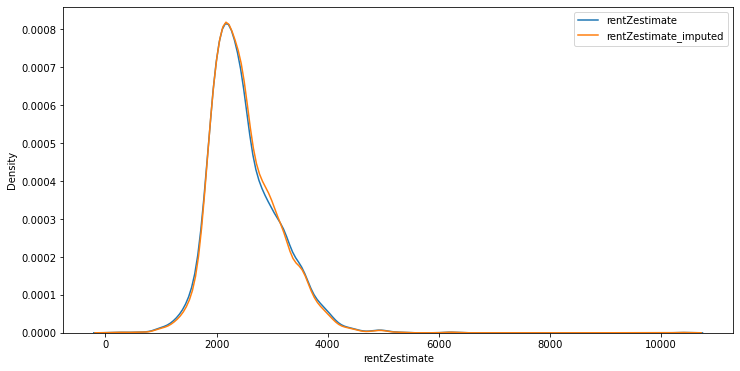

In [50]:
plt.figure(figsize=(12,6))
sns.kdeplot(tmp['rentZestimate'], label='rentZestimate', legend=True)
sns.kdeplot(df_imputed['rentZestimate_i'], label='rentZestimate_imputed', legend=True)
plt.legend();
# Stats
df_concat[['rentZestimate', 'rentZestimate_i']].describe().T

,count,mean,std,min,25%,50%,75%,max
zestimate,3680.0,429131.689946,105649.736027,51000.0,350900.0,412150.0,494975.0,1587200.0
zestimate_i,4611.0,428090.993871,106799.667956,51000.0,350051.0,413700.0,496338.0,1587200.0


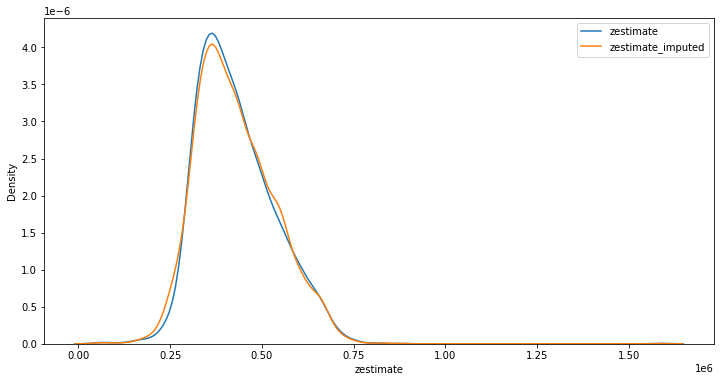

In [51]:
plt.figure(figsize=(12,6))
sns.kdeplot(tmp['zestimate'], label='zestimate', legend=True)
sns.kdeplot(df_imputed['zestimate_i'], label='zestimate_imputed', legend=True)
plt.legend();
# Stats
df_concat[['zestimate', 'zestimate_i']].describe().T

,count,mean,std,min,25%,50%,75%,max
livingArea,4451.0,2265.090317,1016.013336,0.0,1682.5,2249.0,2844.5,8354.0
livingArea_i,4611.0,2246.979284,1005.844250,0.0,1659.0,2228.0,2819.5,8354.0


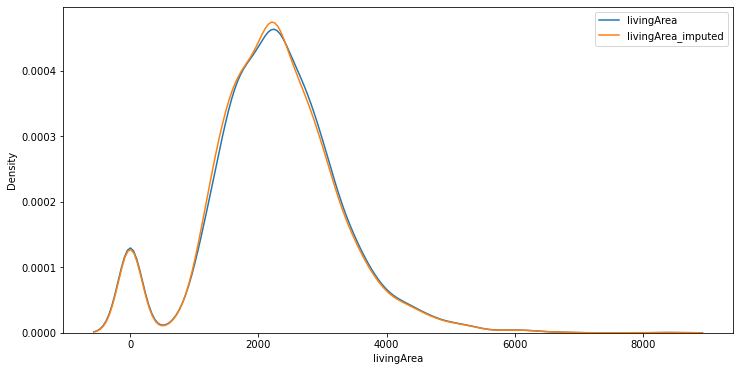

In [52]:
plt.figure(figsize=(12,6))
sns.kdeplot(tmp['livingArea'], label='livingArea', legend=True)
sns.kdeplot(df_imputed['livingArea_i'], label='livingArea_imputed', legend=True)
plt.legend();
# Stats
df_concat[['livingArea', 'livingArea_i']].describe().T

,count,mean,std,min,25%,50%,75%,max
bedrooms,4427.0,3.769596,0.928899,0.0,3.0,4.0,4.0,9.0
bedrooms_i,4611.0,3.723574,0.952921,0.0,3.0,4.0,4.0,9.0


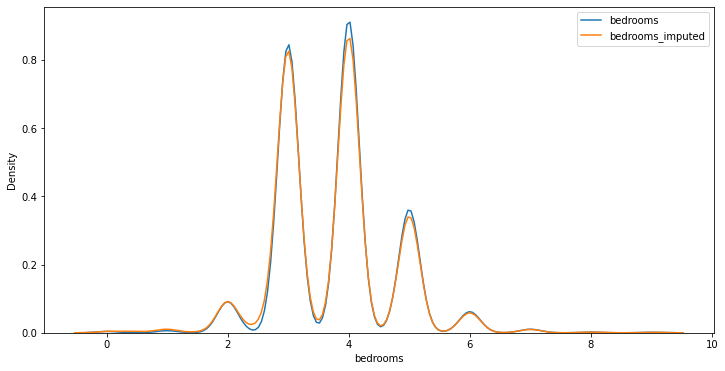

In [53]:
plt.figure(figsize=(12,6))
sns.kdeplot(tmp['bedrooms'], label='bedrooms', legend=True)
sns.kdeplot(df_imputed['bedrooms_i'], label='bedrooms_imputed', legend=True)
plt.legend();
# Stats
df_concat[['bedrooms', 'bedrooms_i']].describe().T

,count,mean,std,min,25%,50%,75%,max
yearBuilt,4447.0,1992.481448,26.432049,1817.0,1978.0,1998.0,2015.0,2023.0
yearBuilt_i,4611.0,1991.800709,26.512019,1817.0,1977.0,1997.0,2014.0,2023.0


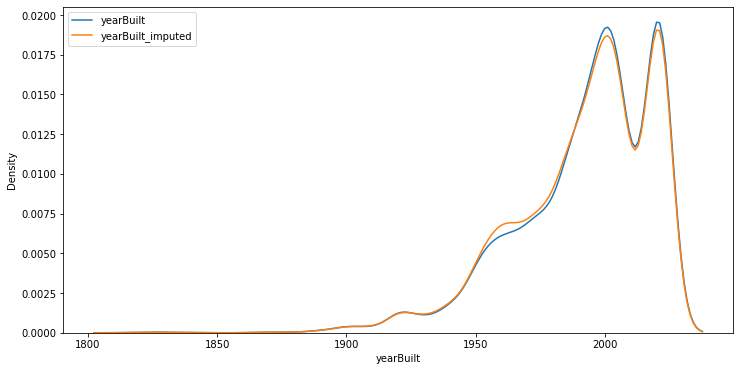

In [54]:
plt.figure(figsize=(12,6))
sns.kdeplot(tmp['yearBuilt'], label='yearBuilt', legend=True)
sns.kdeplot(df_imputed['yearBuilt_i'], label='yearBuilt_imputed', legend=True)
plt.legend();
# Stats
df_concat[['yearBuilt', 'yearBuilt_i']].describe().T

In [55]:
df_concat.to_csv('df_concat.csv', index=False)

In [56]:
df_concat.shape

(4611, 17)

In [57]:
df_concat.columns

Index(['zpid', 'zip_x', 'rentZestimate', 'zestimate', 'livingArea',
       'bathrooms', 'bedrooms', 'yearBuilt', 'price', 'zip_y',
       'rentZestimate_i', 'zestimate_i', 'livingArea_i', 'bathrooms_i',
       'bedrooms_i', 'yearBuilt_i', 'price_i'],
      dtype='object')

#### <font color='blue'> Assigning the imputed values to missing values

In [58]:
df_concat['rentZestimate'] = df_concat['rentZestimate'].fillna(df_concat['rentZestimate_i'])
df_concat['zestimate'] = df_concat['zestimate'].fillna(df_concat['zestimate_i'])
df_concat['livingArea'] = df_concat['livingArea'].fillna(df_concat['livingArea_i'])
df_concat['bathrooms'] = df_concat['bathrooms'].fillna(df_concat['bathrooms_i'])
df_concat['bedrooms'] = df_concat['bedrooms'].fillna(df_concat['bedrooms_i'])
df_concat['yearBuilt'] = df_concat['yearBuilt'].fillna(df_concat['yearBuilt_i'])

In [59]:
df_concat.drop(columns=['zip_x','zip_y',
       'rentZestimate_i', 'zestimate_i', 'livingArea_i', 'bathrooms_i',
       'bedrooms_i', 'yearBuilt_i', 'price_i'], inplace=True)

In [60]:
df_concat.shape

(4611, 8)

In [61]:
df_concat.head()

,zpid,rentZestimate,zestimate,livingArea,bathrooms,bedrooms,yearBuilt,price
0,2.064281e+09,2187.90,349831.00,2103.0,2.0,4.0,2020.0,339900.0
1,9.103072e+07,2600.00,325200.00,2269.0,3.0,5.0,2004.0,305000.0
2,1.112422e+08,1999.00,340500.00,1846.0,2.0,3.0,2004.0,320000.0
3,2.090936e+09,1999.00,343686.00,1953.0,2.0,3.0,2018.0,0.0
4,2.064330e+09,1941.93,372880.05,1835.0,2.0,3.0,2022.0,369900.0


In [62]:
df_upload.shape

(5146, 5)

In [63]:
df_upload_unique.shape

(4612, 5)

## <font color = blue> Putting the zillow data together by joining with imputed values, GA listings and de-duping
### <font color = blue> Process Steps:
* Create "df" as a temporary data frame that has zpid and imputed values as well as original addresses sent to zillow API
* Read the GA listings again into "df_orig" and join with df
* Merge the two data sets by creating a "final_df_start" data frame
* Then bring back all the remaining zilliw attrbutes that did not go through imputation but are useful, this data frame is called as "final_df_end"
* Save this data frame as "clean_df.csv", this will help other team members use this data


In [64]:
df = pd.merge(df_concat, df_upload_unique, how="inner", on="zpid")

In [65]:
df.shape

(4611, 12)

In [66]:
df.head()

,zpid,rentZestimate,zestimate,livingArea,bathrooms,bedrooms,yearBuilt,price,address,city,state,zip
0,2.064281e+09,2187.90,349831.00,2103.0,2.0,4.0,2020.0,339900.0,101 College Street,Kingsland,Georgia,31548
1,9.103072e+07,2600.00,325200.00,2269.0,3.0,5.0,2004.0,305000.0,169 School House Creek Drive,Saint Marys,Georgia,31558
2,1.112422e+08,1999.00,340500.00,1846.0,2.0,3.0,2004.0,320000.0,1621 Sandpiper Court,Saint Marys,Georgia,31558
3,2.090936e+09,1999.00,343686.00,1953.0,2.0,3.0,2018.0,0.0,346 Laurel Landing Boulevard,Kingsland,Georgia,31548
4,2.064330e+09,1941.93,372880.05,1835.0,2.0,3.0,2022.0,369900.0,81 Ossabaw Way,Waverly,Georgia,31565


In [67]:
#df_orig = pd.read_csv('out_v2.csv')

In [68]:
df_orig = pd.read_csv('tax_data.csv')

In [69]:
df_orig.head()

,latitude,longitude,full_street_address,city,county_name,baths_half,details,special_features,price,transaction_type,listing_status,listing_special_features,census_state_name,census_county_name,zip,beds,baths_full,year_built,square_footage,PCT_CHG,Individuals_taxed,Elderly_taxed,Total_AGI,Number_of_returns,Total_income,Income_per_return,Int_Number of returns,Int_Amount,Int_earned,Cap_gain,Pension,UE_claims,Social_security,SB_income,Student_loan_ded,RE_taxes,PP_taxes,Mortgage_Int_paid,Taxable_inc,Child_credit,Earned_Inc_credit
0,30.804209,-81.653325,101 College Street,Kingsland,Camden-County,0.0,Detached,2,339900,1,1,2,Georgia,"Camden, GA",31548,4.0,2.0,2020.0,2103.0,0.117940,20160.0,1820.0,511435.0,9720.0,515826.0,53.068519,2170.0,1616.0,0.744700,6.500000,25.879817,3.546154,12.728319,36.895652,1.067021,3.122857,0.676744,8.708955,43.969231,2.125743,2.585463
1,30.767365,-81.588272,169 School House Creek Drive,Saint Marys,Camden-County,0.0,Detached,0,310000,1,1,0,Georgia,"Camden, GA",31558,5.0,3.0,2004.0,2269.0,0.113899,18840.0,2230.0,553832.0,9270.0,558674.0,60.266882,2500.0,3254.0,1.301600,17.274138,29.575630,3.477778,17.108497,46.670968,1.004819,4.105556,0.758537,10.493939,50.748133,2.175097,2.555497
2,30.746731,-81.633995,1621 Sandpiper Court,Saint Marys,Camden-County,0.0,Detached,0,315000,1,1,0,Georgia,"Camden, GA",31558,3.0,2.0,2004.0,1846.0,0.113899,18840.0,2230.0,553832.0,9270.0,558674.0,60.266882,2500.0,3254.0,1.301600,17.274138,29.575630,3.477778,17.108497,46.670968,1.004819,4.105556,0.758537,10.493939,50.748133,2.175097,2.555497
3,30.791878,-81.676750,346 Laurel Landing Boulevard,Kingsland,Camden-County,0.0,Detached,0,310000,1,1,0,Georgia,"Camden, GA",31548,3.0,2.0,2017.0,1977.0,0.117940,20160.0,1820.0,511435.0,9720.0,515826.0,53.068519,2170.0,1616.0,0.744700,6.500000,25.879817,3.546154,12.728319,36.895652,1.067021,3.122857,0.676744,8.708955,43.969231,2.125743,2.585463
4,31.104492,-81.604486,81 Ossabaw Way,Waverly,Camden-County,0.0,Detached,2,369900,1,1,2,Georgia,"Camden, GA",31565,3.0,2.0,2022.0,1835.0,0.020674,1800.0,280.0,61680.0,930.0,62196.0,66.877419,290.0,475.0,1.637931,6.375000,32.572000,0.000000,17.610526,65.228571,1.160000,4.311111,0.400000,10.333333,58.208108,1.936000,2.294118


In [70]:
df_orig.shape

(5397, 41)

In [71]:
df_orig.rename(columns={"full_street_address": "address"}, inplace=True)

In [72]:
df_orig.shape

(5397, 41)

In [73]:
df_orig.columns

Index(['latitude', 'longitude', 'address', 'city', 'county_name', 'baths_half',
       'details', 'special_features', 'price', 'transaction_type',
       'listing_status', 'listing_special_features', 'census_state_name',
       'census_county_name', 'zip', 'beds', 'baths_full', 'year_built',
       'square_footage', 'PCT_CHG', 'Individuals_taxed', 'Elderly_taxed',
       'Total_AGI', 'Number_of_returns', 'Total_income', 'Income_per_return',
       'Int_Number of returns', 'Int_Amount', 'Int_earned', 'Cap_gain',
       'Pension', 'UE_claims', 'Social_security', 'SB_income',
       'Student_loan_ded', 'RE_taxes', 'PP_taxes', 'Mortgage_Int_paid',
       'Taxable_inc', 'Child_credit', 'Earned_Inc_credit'],
      dtype='object')

In [74]:
df.columns

Index(['zpid', 'rentZestimate', 'zestimate', 'livingArea', 'bathrooms',
       'bedrooms', 'yearBuilt', 'price', 'address', 'city', 'state', 'zip'],
      dtype='object')

In [75]:
final_df_start = pd.merge(df, df_orig, how="inner", on=['zip','city','address'])

In [76]:
final_df_start.shape

(4964, 50)

In [77]:
len(final_df_start.zpid.unique())

4591

In [78]:
final_df_start = final_df_start.drop_duplicates(subset=['zpid'], keep='first')

In [79]:
final_df_start.shape

(4591, 50)

In [80]:
final_df_end = pd.merge(final_df_start, remaining_tmp, how="inner", on=['zpid'])

In [81]:
final_df_start = final_df_start.drop_duplicates(subset=['zpid'], keep='first')

In [82]:
final_df_end.shape

(4591, 77)

In [83]:
final_df_end.head()

,zpid,rentZestimate,zestimate,livingArea,bathrooms,bedrooms,yearBuilt,price_x,address,city,state,zip,latitude,longitude,county_name,baths_half,details,special_features,price_y,transaction_type,listing_status,listing_special_features,census_state_name,census_county_name,beds,baths_full,year_built,square_footage,PCT_CHG,Individuals_taxed,Elderly_taxed,Total_AGI,Number_of_returns,Total_income,Income_per_return,Int_Number of returns,Int_Amount,Int_earned,Cap_gain,Pension,UE_claims,Social_security,SB_income,Student_loan_ded,RE_taxes,PP_taxes,Mortgage_Int_paid,Taxable_inc,Child_credit,Earned_Inc_credit,propertyTaxRate,pricePerSquareFoot,propertyTypeDimension,annualHomeownersInsurance,monthlyHoaFee,taxAnnualAmount,dateSold,pageViewCount,description,homeStatus,favoriteCount,schools,streetAddress,hasAttachedProperty,poolFeatures,flooring,hasGarage,parking,hasWaterfrontView,lotSize,architecturalStyle,structureType,appliances,communityFeatures,propertyCondition,utilities,url
0,2.064281e+09,2187.90,349831.00,2103.0,2.0,4.0,2020.0,339900.0,101 College Street,Kingsland,Georgia,31548,30.804209,-81.653325,Camden-County,0.0,Detached,2,339900,1,1,2,Georgia,"Camden, GA",4.0,2.0,2020.0,2103.0,0.117940,20160.0,1820.0,511435.0,9720.0,515826.0,53.068519,2170.0,1616.0,0.744700,6.500000,25.879817,3.546154,12.728319,36.895652,1.067021,3.122857,0.676744,8.708955,43.969231,2.125743,2.585463,0.98,162.0,Single Family,1428.0,8.0,3670.0,2022-05-31,0.0,"Looking for your new ""Home Sweet Home"" that ha...",RECENTLY_SOLD,0.0,[{'link': 'https://www.greatschools.org/school...,101 College St,False,NaN,"['Carpet', 'Tile']",True,2.0,NaN,0.45 Acres,Other,NaN,"['Some Electric Appliances', 'Dishwasher', 'Di...","['Street Lights', 'Sidewalks', 'Walk to School']",NaN,"['Cable Available', 'Sewer Available', 'Sewer ...",/homedetails/101-College-St-Kingsland-GA-31548...
1,9.103072e+07,2600.00,325200.00,2269.0,3.0,5.0,2004.0,305000.0,169 School House Creek Drive,Saint Marys,Georgia,31558,30.767365,-81.588272,Camden-County,0.0,Detached,0,310000,1,1,0,Georgia,"Camden, GA",5.0,3.0,2004.0,2269.0,0.113899,18840.0,2230.0,553832.0,9270.0,558674.0,60.266882,2500.0,3254.0,1.301600,17.274138,29.575630,3.477778,17.108497,46.670968,1.004819,4.105556,0.758537,10.493939,50.748133,2.175097,2.555497,0.98,134.0,Single Family,1281.0,NaN,3211.0,2022-05-17,6.0,"Hard to find 5 bedroom, 3 bath home in SugarMi...",RECENTLY_SOLD,0.0,[{'link': 'https://www.greatschools.org/school...,169 School House Creek Dr,False,NaN,"['Carpet', 'Laminate', 'Vinyl']",True,0.0,NaN,"7,840 sqft",Traditional,House,"['Dishwasher', 'Oven/Range (Combo)', 'Refriger...","['Sidewalks', 'Street Lights']",Resale,"['Underground Utilities', 'Cable Available', '...",/homedetails/169-School-House-Creek-Dr-Saint-M...
2,1.112422e+08,1999.00,340500.00,1846.0,2.0,3.0,2004.0,320000.0,1621 Sandpiper Court,Saint Marys,Georgia,31558,30.746731,-81.633995,Camden-County,0.0,Detached,0,315000,1,1,0,Georgia,"Camden, GA",3.0,2.0,2004.0,1846.0,0.113899,18840.0,2230.0,553832.0,9270.0,558674.0,60.266882,2500.0,3254.0,1.301600,17.274138,29.575630,3.477778,17.108497,46.670968,1.004819,4.105556,0.758537,10.493939,50.748133,2.175097,2.555497,0.98,173.0,Single Family,1344.0,210.0,3618.0,2022-05-13,20.0,"Beautiful, coastal patio home with calming ""Se...",RECENTLY_SOLD,0.0,[{'link': 'https://www.greatschools.org/school...,1621 Sandpiper Ct,False,['None'],['Tile'],True,2.0,NaN,"8,276 sqft",Patio Home,NaN,"['Dryer', 'Dishwasher', 'Disposal', 'Microwave...","['Boat Facilities', 'Gated', 'Park', 'Street L...",NaN,"['Sewer Available', 'Sewer Connected', 'Underg...",/homedetails/1621-Sandpiper-Ct-Saint-Marys-GA-...
3,2.090936e+09,1999.00,343686.00,1953.0,2.0,3.0,2018.0,0.0,346 Laurel Landing Boulevard,Kingsland,Georgia,31548,30.791878,-81.676750,Camden-County,0.0,Detached,0,310000,1,1,0,Georgia,"Camden, GA",3.0,2.0,2017.0,1977.0,0.117940,20160.0,1820.0,511435.0,9720.0,515826.0,53.068519,2170.0,1616.0,0.744700,6.500000,25.879817,3.546154,12.728319,36.895652,1.

In [84]:
#final_df_end.to_csv('clean_df.csv', index=False)

In [85]:
final_df_end.describe().T

,count,mean,std,min,25%,50%,75%,max
zpid,4591.0,4.638637e+08,7.922417e+08,1.409882e+07,1.489233e+07,7.112487e+07,2.377148e+08,2.146666e+09
rentZestimate,4591.0,2.493594e+03,6.019081e+02,1.450000e+02,2.094000e+03,2.394000e+03,2.836000e+03,1.038600e+04
zestimate,4591.0,4.282046e+05,1.069205e+05,5.100000e+04,3.500510e+05,4.139000e+05,4.967000e+05,1.587200e+06
livingArea,4591.0,2.247606e+03,1.006192e+03,0.000000e+00,1.660000e+03,2.228000e+03,2.821000e+03,8.354000e+03
bathrooms,4591.0,2.825594e+00,9.532462e-01,0.000000e+00,2.000000e+00,3.000000e+00,3.000000e+00,1.300000e+01
bedrooms,4591.0,3.726700e+00,9.522127e-01,0.000000e+00,3.000000e+00,4.000000e+00,4.000000e+00,9.000000e+00
yearBuilt,4591.0,1.991783e+03,2.652799e+01,1.817000e+03,1.976625e+03,1.997000e+03,2.014000e+03,2.023000e+03
price_x,4588.0,3.984831e+05,1.446026e+05,0.000000e+00,3.308750e+05,4.000000e+05,4.855000e+05,2.800000e+06
zip,4591.0,3.036347e+04,5.096866e+02,3.000200e+04,3.008300e+04,3.022400e+04,3.052300e+04,3.985400e+04
latitude,4591.0,3.370661e+01,6.507779e-01,3.036108e+01,3.353940e+01,3.382792e+01,3.404775e+01,3.499049e+01


## <font color = 'blue'> Extract schools information from Zillow data

In [86]:
schools = pd.DataFrame()

In [87]:
final_df_end.schools[0]

"[{'link': 'https://www.greatschools.org/school?id=00282&state=GA', 'rating': 7, 'totalCount': 1, 'distance': 0.4, 'assigned': None, 'name': 'Matilda Harris Elementary School', 'studentsPerTeacher': 17, 'isAssigned': True, 'size': 588, 'level': 'Primary', 'grades': 'PK-5', 'type': 'Public'}, {'link': 'https://www.greatschools.org/school?id=00278&state=GA', 'rating': 6, 'totalCount': 1, 'distance': 0.8, 'assigned': None, 'name': 'Camden Middle School', 'studentsPerTeacher': 16, 'isAssigned': True, 'size': 1046, 'level': 'Middle', 'grades': '6-8', 'type': 'Public'}, {'link': 'https://www.greatschools.org/school?id=00275&state=GA', 'rating': 9, 'totalCount': 1, 'distance': 1, 'assigned': None, 'name': 'Camden County High School', 'studentsPerTeacher': 16, 'isAssigned': True, 'size': 2504, 'level': 'High', 'grades': '9-12', 'type': 'Public'}]"

In [88]:
schools[['elemtary','middle','high']] = final_df_end.schools.str.split("}, {",expand = True)

In [89]:
schools[['elem_link','elem_rating','elem_count','elem_distance',
        'elem_assigned','elem_name','elem_spt','elem_isassigned','elem_size',
        'elem_level','elem_grades','elem_type']] = schools.elemtary.str.split(", '", expand =True)
schools[['mid_link','mid_rating','mid_count','mid_distance',
        'mid_assigned','mid_name','mid_spt','mid_isassigned','mid_size',
        'mid_level','mid_grades','mid_type']] = schools.middle.str.split(", '", expand =True)
schools[['high_link','high_rating','high_count','high_distance',
        'high_assigned','high_name','high_spt','high_isassigned','high_size',
        'high_level','high_grades','high_type']] = schools.high.str.split(", '", expand =True)

In [90]:
schools.columns

Index(['elemtary', 'middle', 'high', 'elem_link', 'elem_rating', 'elem_count',
       'elem_distance', 'elem_assigned', 'elem_name', 'elem_spt',
       'elem_isassigned', 'elem_size', 'elem_level', 'elem_grades',
       'elem_type', 'mid_link', 'mid_rating', 'mid_count', 'mid_distance',
       'mid_assigned', 'mid_name', 'mid_spt', 'mid_isassigned', 'mid_size',
       'mid_level', 'mid_grades', 'mid_type', 'high_link', 'high_rating',
       'high_count', 'high_distance', 'high_assigned', 'high_name', 'high_spt',
       'high_isassigned', 'high_size', 'high_level', 'high_grades',
       'high_type'],
      dtype='object')

In [91]:
schools = schools[['elem_rating','elem_count','elem_distance','elem_assigned','elem_name','elem_spt',
        'elem_isassigned','elem_size','elem_type','mid_rating','mid_count','mid_distance',
        'mid_assigned','mid_name','mid_spt','mid_isassigned','mid_size','mid_type',
        'high_rating','high_count','high_distance','high_assigned','high_name','high_spt',
        'high_isassigned','high_size','high_type']]

In [92]:
schools.elem_rating.str.split(': ',).str[1]

0          7
1          6
2          6
3          7
4          7
        ... 
4586       4
4587       4
4588       4
4589       4
4590    None
Name: elem_rating, Length: 4591, dtype: object

In [93]:
schools.head()

,elem_rating,elem_count,elem_distance,elem_assigned,elem_name,elem_spt,elem_isassigned,elem_size,elem_type,mid_rating,mid_count,mid_distance,mid_assigned,mid_name,mid_spt,mid_isassigned,mid_size,mid_type,high_rating,high_count,high_distance,high_assigned,high_name,high_spt,high_isassigned,high_size,high_type
0,rating': 7,totalCount': 1,distance': 0.4,assigned': None,name': 'Matilda Harris Elementary School',studentsPerTeacher': 17,isAssigned': True,size': 588,type': 'Public',rating': 6,totalCount': 1,distance': 0.8,assigned': None,name': 'Camden Middle School',studentsPerTeacher': 16,isAssigned': True,size': 1046,type': 'Public',rating': 9,totalCount': 1,distance': 1,assigned': None,name': 'Camden County High School',studentsPerTeacher': 16,isAssigned': True,size': 2504,type': 'Public'}]
1,rating': 6,totalCount': 1,distance': 0.2,assigned': None,name': 'Mary Lee Clark Elementary School',studentsPerTeacher': 17,isAssigned': True,size': 541,type': 'Public',rating': 8,totalCount': 1,distance': 1.3,assigned': None,name': 'Saint Marys Middle School',studentsPerTeacher': 16,isAssigned': True,size': 1020,type': 'Public',rating': 9,totalCount': 1,distance': 4.8,assigned': None,name': 'Camden County High School',studentsPerTeacher': 16,isAssigned': True,size': 2504,type': 'Public'}]
2,rating': 6,totalCount': 1,distance': 3,assigned': None,name': 'Mary Lee Clark Elementary School',studentsPerTeacher': 17,isAssigned': True,size': 541,type': 'Public',rating': 8,totalCount': 1,distance': 3.8,assigned': None,name': 'Saint Marys Middle School',studentsPerTeacher': 16,isAssigned': True,size': 1020,type': 'Public',rating': 9,totalCount': 1,distance': 4.5,assigned': None,name': 'Camden County High School',studentsPerTeacher': 16,isAssigned': True,size': 2504,type': 'Public'}]
3,rating': 7,totalCount': 1,distance': 1.6,assigned': None,name': 'Sugarmill Elementary School',studentsPerTeacher': 18,isAssigned': True,size': 566,type': 'Public',rating': 8,totalCount': 1,distance': 4.5,assigned': None,name': 'Saint Marys Middle School',studentsPerTeacher': 16,isAssigned': True,size': 1020,type': 'Public',rating': 9,totalCount': 1,distance': 1.7,assigned': None,name': 'Camden County High School',studentsPerTeacher': 16,isAssigned': True,size': 2504,type': 'Public'}]
4,rating': 7,totalCount': 1,distance': 10.9,assigned': None,name': 'Woodbine Elementary School',studentsPerTeacher': 16,isAssigned': True,size': 414,type': 'Public',rating': 6,totalCount': 1,distance': 19.6,assigned': None,name': 'Camden Middle School',studentsPerTeacher': 16,isAssigned': True,size': 1046,type': 'Public',rating': 9,totalCount': 1,distance': 18.1,assigned': None,name': 'Camden County High School',studentsPerTeacher': 16,isAssigned': True,size': 2504,type': 'Public'}]


In [94]:
#extract only the information
for col in schools.columns:
    schools[col] = schools[col].str.split(': ').str[1]
schools

,elem_rating,elem_count,elem_distance,elem_assigned,elem_name,elem_spt,elem_isassigned,elem_size,elem_type,mid_rating,mid_count,mid_distance,mid_assigned,mid_name,mid_spt,mid_isassigned,mid_size,mid_type,high_rating,high_count,high_distance,high_assigned,high_name,high_spt,high_isassigned,high_size,high_type
0,7,1,0.4,None,'Matilda Harris Elementary School',17,True,588,'Public',6,1,0.8,None,'Camden Middle School',16,True,1046,'Public',9,1,1,None,'Camden County High School',16,True,2504,'Public'}]
1,6,1,0.2,None,'Mary Lee Clark Elementary School',17,True,541,'Public',8,1,1.3,None,'Saint Marys Middle School',16,True,1020,'Public',9,1,4.8,None,'Camden County High School',16,True,2504,'Public'}]
2,6,1,3,None,'Mary Lee Clark Elementary School',17,True,541,'Public',8,1,3.8,None,'Saint Marys Middle School',16,True,1020,'Public',9,1,4.5,None,'Camden County High School',16,True,2504,'Public'}]
3,7,1,1.6,None,'Sugarmill Elementary School',18,True,566,'Public',8,1,4.5,None,'Saint Marys Middle School',16,True,1020,'Public',9,1,1.7,None,'Camden County High School',16,True,2504,'Public'}]
4,7,1,10.9,None,'Woodbine Elementary School',16,True,414,'Public',6,1,19.6,None,'Camden Middle School',16,True,1046,'Public',9,1,18.1,None,'Camden County High School',16,True,2504,'Public'}]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4586,4,2,14.1,None,'Washington-Wilkes Primary School',12,True,438,'Public',6,1,12.3,None,'Washington-Wilkes Middle School',15,True,319,'Public',4,1,12.3,None,'Washington-Wilkes Comprehensive High School',14,True,415,'Public'}]
4587,4,2,1.1,None,'Washington-Wilkes Primary School',12,True,438,'Public',6,1,1.6,None,'Washington-Wilkes Middle School',15,True,319,'Public',4,1,1.6,None,'Washington-Wilkes Comprehensive High School',14,True,415,'Public'}]
4588,4,2,1.1,None,'Washington-Wilkes Primary School',12,True,438,'Public',6,1,1.7,None,'Washington-Wilkes Middle School',15,True,319,'Public',4,1,1.7,None,'Washington-Wilkes Comprehensive High School',14,True,415,'Public'}]
4589,4,2,9.7,None,'Washington-Wilkes Primary School',12,True,438,'Public',6,1,8.5,None,'Washington-Wilkes Middle School',15,True,319,'Public',4,1,8.6,None,'Washington-Wilkes Comprehensive High School',14,True,415,'Public'}]


In [95]:
# Remove punctuations
#schools.elem_name = schools.elem_name.str.replace("'","")
#schools.elem_type = schools.elem_type.str.replace("'","")
#schools.mid_name = schools.mid_name.str.replace("'","")
#schools.mid_type = schools.mid_type.str.replace("'","")
#schools.high_name = schools.high_name.str.replace("'","")
schools.high_type = schools.high_type.str.replace("}]","")

/var/folders/jr/_gd99zyd2gg8ks3xkxshk6240000gn/T/ipykernel_72664/3375396239.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  schools.high_type = schools.high_type.str.replace("}]","")


In [96]:
schools.columns

Index(['elem_rating', 'elem_count', 'elem_distance', 'elem_assigned',
       'elem_name', 'elem_spt', 'elem_isassigned', 'elem_size', 'elem_type',
       'mid_rating', 'mid_count', 'mid_distance', 'mid_assigned', 'mid_name',
       'mid_spt', 'mid_isassigned', 'mid_size', 'mid_type', 'high_rating',
       'high_count', 'high_distance', 'high_assigned', 'high_name', 'high_spt',
       'high_isassigned', 'high_size', 'high_type'],
      dtype='object')

In [97]:
schools.elem_rating.value_counts()

6       1047
5        768
7        630
4        581
8        523
3        368
9        211
None     207
2        170
1         63
10        20
Name: elem_rating, dtype: int64

In [98]:
# Replace missing value with np.nan
schools[['elem_rating','elem_count','elem_distance', 'elem_spt','elem_size',
        'mid_rating','mid_count', 'mid_distance','mid_spt','mid_size',
        'high_rating','high_count', 'high_distance','high_spt','high_size']]=schools[['elem_rating','elem_count','elem_distance', 'elem_spt','elem_size',
        'mid_rating','mid_count', 'mid_distance','mid_spt','mid_size',
        'high_rating','high_count', 'high_distance','high_spt','high_size']].replace('None',np.nan)

In [99]:
# Conver to float
schools[['elem_rating','elem_count','elem_spt','elem_size',
        'mid_rating','mid_count','mid_spt','mid_size',
        'high_rating','high_count','high_spt','high_size']].astype(float)

,elem_rating,elem_count,elem_spt,elem_size,mid_rating,mid_count,mid_spt,mid_size,high_rating,high_count,high_spt,high_size
0,7.0,1.0,17.0,588.0,6.0,1.0,16.0,1046.0,9.0,1.0,16.0,2504.0
1,6.0,1.0,17.0,541.0,8.0,1.0,16.0,1020.0,9.0,1.0,16.0,2504.0
2,6.0,1.0,17.0,541.0,8.0,1.0,16.0,1020.0,9.0,1.0,16.0,2504.0
3,7.0,1.0,18.0,566.0,8.0,1.0,16.0,1020.0,9.0,1.0,16.0,2504.0
4,7.0,1.0,16.0,414.0,6.0,1.0,16.0,1046.0,9.0,1.0,16.0,2504.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4586,4.0,2.0,12.0,438.0,6.0,1.0,15.0,319.0,4.0,1.0,14.0,415.0
4587,4.0,2.0,12.0,438.0,6.0,1.0,15.0,319.0,4.0,1.0,14.0,415.0
4588,4.0,2.0,12.0,438.0,6.0,1.0,15.0,319.0,4.0,1.0,14.0,415.0
4589,4.0,2.0,12.0,438.0,6.0,1.0,15.0,319.0,4.0,1.0,14.0,415.0


In [100]:
final_df_end.shape

(4591, 77)

In [101]:
schools.shape

(4591, 27)

In [102]:
#df_col_merged = pd.concat([df_a, df_b], axis=1)
df_zill_school = pd.concat([final_df_end, schools], axis=1)

In [103]:
df_zill_school.shape

(4591, 104)

In [104]:
#df_zill_school = pd.read_csv('clean_df_schools.csv')  

In [105]:
df_zill_school.columns

Index(['zpid', 'rentZestimate', 'zestimate', 'livingArea', 'bathrooms',
       'bedrooms', 'yearBuilt', 'price_x', 'address', 'city',
       ...
       'mid_type', 'high_rating', 'high_count', 'high_distance',
       'high_assigned', 'high_name', 'high_spt', 'high_isassigned',
       'high_size', 'high_type'],
      dtype='object', length=104)

In [106]:
df_zill_school.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4591 entries, 0 to 4590
Columns: 104 entries, zpid to high_type
dtypes: float64(45), int64(6), object(53)
memory usage: 3.8+ MB


### <font color = 'red'> We are doing feature engineering here to get average school rating in the neighborhood, total schools available to the property and average distance to a school from a given property

In [107]:
cols = ['elem_rating','mid_rating','high_rating',
       'elem_count','mid_count','high_count',
       'elem_distance','mid_distance','high_distance']

In [108]:
cols

['elem_rating',
 'mid_rating',
 'high_rating',
 'elem_count',
 'mid_count',
 'high_count',
 'elem_distance',
 'mid_distance',
 'high_distance']

In [109]:
df_zill_school[cols] = df_zill_school[cols].apply(pd.to_numeric, errors='coerce')

In [110]:
df_zill_school.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4591 entries, 0 to 4590
Columns: 104 entries, zpid to high_type
dtypes: float64(54), int64(6), object(44)
memory usage: 3.8+ MB


In [111]:
#df['avg'] = df.mean(axis=1)
sr = df_zill_school[['elem_rating','mid_rating','high_rating']]
sc = df_zill_school[['elem_count','mid_count','high_count']]
sd = df_zill_school[['elem_distance','mid_distance','high_distance']]

In [112]:
df_zill_school['sch_rating_avg'] = sr.mean(axis =1)
df_zill_school['sch_cnt'] = sc.sum(axis =1)
df_zill_school['sch_dist_avg'] = sd.mean(axis =1)

In [113]:
df_zill_school.head()

,zpid,rentZestimate,zestimate,livingArea,bathrooms,bedrooms,yearBuilt,price_x,address,city,state,zip,latitude,longitude,county_name,baths_half,details,special_features,price_y,transaction_type,listing_status,listing_special_features,census_state_name,census_county_name,beds,baths_full,year_built,square_footage,PCT_CHG,Individuals_taxed,Elderly_taxed,Total_AGI,Number_of_returns,Total_income,Income_per_return,Int_Number of returns,Int_Amount,Int_earned,Cap_gain,Pension,UE_claims,Social_security,SB_income,Student_loan_ded,RE_taxes,PP_taxes,Mortgage_Int_paid,Taxable_inc,Child_credit,Earned_Inc_credit,propertyTaxRate,pricePerSquareFoot,propertyTypeDimension,annualHomeownersInsurance,monthlyHoaFee,taxAnnualAmount,dateSold,pageViewCount,description,homeStatus,favoriteCount,schools,streetAddress,hasAttachedProperty,poolFeatures,flooring,hasGarage,parking,hasWaterfrontView,lotSize,architecturalStyle,structureType,appliances,communityFeatures,propertyCondition,utilities,url,elem_rating,elem_count,elem_distance,elem_assigned,elem_name,elem_spt,elem_isassigned,elem_size,elem_type,mid_rating,mid_count,mid_distance,mid_assigned,mid_name,mid_spt,mid_isassigned,mid_size,mid_type,high_rating,high_count,high_distance,high_assigned,high_name,high_spt,high_isassigned,high_size,high_type,sch_rating_avg,sch_cnt,sch_dist_avg
0,2.064281e+09,2187.90,349831.00,2103.0,2.0,4.0,2020.0,339900.0,101 College Street,Kingsland,Georgia,31548,30.804209,-81.653325,Camden-County,0.0,Detached,2,339900,1,1,2,Georgia,"Camden, GA",4.0,2.0,2020.0,2103.0,0.117940,20160.0,1820.0,511435.0,9720.0,515826.0,53.068519,2170.0,1616.0,0.744700,6.500000,25.879817,3.546154,12.728319,36.895652,1.067021,3.122857,0.676744,8.708955,43.969231,2.125743,2.585463,0.98,162.0,Single Family,1428.0,8.0,3670.0,2022-05-31,0.0,"Looking for your new ""Home Sweet Home"" that ha...",RECENTLY_SOLD,0.0,[{'link': 'https://www.greatschools.org/school...,101 College St,False,NaN,"['Carpet', 'Tile']",True,2.0,NaN,0.45 Acres,Other,NaN,"['Some Electric Appliances', 'Dishwasher', 'Di...","['Street Lights', 'Sidewalks', 'Walk to School']",NaN,"['Cable Available', 'Sewer Available', 'Sewer ...",/homedetails/101-College-St-Kingsland-GA-31548...,7.0,1.0,0.4,None,'Matilda Harris Elementary School',17,True,588,'Public',6.0,1.0,0.8,None,'Camden Middle School',16,True,1046,'Public',9.0,1.0,1.0,None,'Camden County High School',16,True,2504,'Public',7.333333,3.0,0.733333
1,9.103072e+07,2600.00,325200.00,2269.0,3.0,5.0,2004.0,305000.0,169 School House Creek Drive,Saint Marys,Georgia,31558,30.767365,-81.588272,Camden-County,0.0,Detached,0,310000,1,1,0,Georgia,"Camden, GA",5.0,3.0,2004.0,2269.0,0.113899,18840.0,2230.0,553832.0,9270.0,558674.0,60.266882,2500.0,3254.0,1.301600,17.274138,29.575630,3.477778,17.108497,46.670968,1.004819,4.105556,0.758537,10.493939,50.748133,2.175097,2.555497,0.98,134.0,Single Family,1281.0,NaN,3211.0,2022-05-17,6.0,"Hard to find 5 bedroom, 3 bath home in SugarMi...",RECENTLY_SOLD,0.0,[{'link': 'https://www.greatschools.org/school...,169 School House Creek Dr,False,NaN,"['Carpet', 'Laminate', 'Vinyl']",True,0.0,NaN,"7,840 sqft",Traditional,House,"['Dishwasher', 'Oven/Range (Combo)', 'Refriger...","['Sidewalks', 'Street Lights']",Resale,"['Underground Utilities', 'Cable Available', '...",/homedetails/169-School-House-Creek-Dr-Saint-M...,6.0,1.0,0.2,None,'Mary Lee Clark Elementary School',17,True,541,'Public',8.0,1.0,1.3,None,'Saint Marys Middle School',16,True,1020,'Public',9.0,1.0,4.8,None,'Camden County High School',16,True,2504,'Public',7.666667,3.0,2.100000
2,1.112422e+08,1999.00,340500.00,1846.0,2.0,3.0,2004.0,320000.0,1621 Sandpiper Court,Saint Marys,Georgia,31558,30.746731,-81.633995,Camden-County,0.0,Detached,0,315000,1,1,0,Georgia,"Camden, GA",3.0,2.0,2004.0,1846.0,0.113899,18840.0,2230.0,553832.0,9270.0,558674.0,60.266882,2500.0,3254.0,1.301600,17.274138,29.575630,3.477778,17.108497,46.670968,1.004819,4.105556,0.758537,10.493939,50.748133,2.175097,2.555497,0.98,173.0,Single Family,13

In [114]:
df_zill_school.columns

Index(['zpid', 'rentZestimate', 'zestimate', 'livingArea', 'bathrooms',
       'bedrooms', 'yearBuilt', 'price_x', 'address', 'city',
       ...
       'high_distance', 'high_assigned', 'high_name', 'high_spt',
       'high_isassigned', 'high_size', 'high_type', 'sch_rating_avg',
       'sch_cnt', 'sch_dist_avg'],
      dtype='object', length=107)

## Zillow, School and Tax (ZST) subset. Note that df_zill_schools dataframe can be used to extract more features (total 107 features in the data frame)

### Using Tax data to Identify wealthy Neighborhoods 

### <font color='red'> The tax data attributes are used to proxy wealthy zipcodes:
* Higher Income per return
* Higher Capital Gains - associated with wealthy tax payers
* Lower Unemployment claims 
* Higher Personal Property taxes
* Lower Earned Income Tax Credits    
    
Data Processing Steps:
1. Merge Zillow Data, which includes Schools info, with Tax information
1. Review correlations and remove highly correlated variables    

In [115]:
df_zst = df_zill_school[['zpid', 'rentZestimate', 'zestimate', 'livingArea', 'bathrooms',
       'bedrooms', 'yearBuilt', 'address', 'city', 'state', 'zip',
       'latitude', 'longitude', 'square_footage',
       'price_y', 'PCT_CHG',
       'census_county_name',
       'beds', 'baths_full', 'year_built', 'propertyTaxRate',
       'pricePerSquareFoot', 'propertyTypeDimension',
       'taxAnnualAmount',
       'dateSold', 'pageViewCount', 
       'hasAttachedProperty',
       'poolFeatures', 'flooring', 'hasGarage', 'parking', 'hasWaterfrontView',
       'lotSize','appliances',
       'communityFeatures', 'propertyCondition','sch_rating_avg',
       'sch_cnt', 'sch_dist_avg',
       'Individuals_taxed',
       'Income_per_return', 'Cap_gain', 'Pension', 'UE_claims', 'Social_security',
       'SB_income', 'Student_loan_ded', 'RE_taxes', 'PP_taxes',
       'Child_credit', 'Earned_Inc_credit'                        ]]

In [116]:
df_zst.isna().sum()

zpid                        0
rentZestimate               0
zestimate                   0
livingArea                  0
bathrooms                   0
bedrooms                    0
yearBuilt                   0
address                     0
city                        0
state                       0
zip                         0
latitude                    0
longitude                   0
square_footage              0
price_y                     0
PCT_CHG                     0
census_county_name          0
beds                        0
baths_full                  0
year_built                  0
propertyTaxRate             3
pricePerSquareFoot        465
propertyTypeDimension       3
taxAnnualAmount           556
dateSold                  579
pageViewCount               4
hasAttachedProperty         3
poolFeatures             3022
flooring                  608
hasGarage                   3
parking                     3
hasWaterfrontView        4112
lotSize                   325
appliances

In [117]:
# import modules
import matplotlib.pyplot as mp
import pandas as pd
import seaborn as sb

# columns shown here are selected by corr() since
# they are ideal for the plot
print(df_zst.corr())
  

                        zpid  rentZestimate  zestimate  livingArea  bathrooms  \
zpid                1.000000      -0.008044   0.019784    0.025678  -0.003354   
rentZestimate      -0.008044       1.000000   0.773618    0.502498   0.505310   
zestimate           0.019784       0.773618   1.000000    0.428252   0.480732   
livingArea          0.025678       0.502498   0.428252    1.000000   0.524229   
bathrooms          -0.003354       0.505310   0.480732    0.524229   1.000000   
bedrooms            0.017146       0.436393   0.353700    0.489766   0.641699   
yearBuilt           0.375059       0.173799   0.248462    0.220179   0.358062   
zip                 0.140521       0.019956  -0.040936    0.043260  -0.002396   
latitude           -0.119716      -0.042088   0.066478   -0.115070  -0.047549   
longitude           0.133902       0.024000  -0.008761    0.057540   0.012705   
square_footage      0.080387       0.560557   0.474432    0.665705   0.553767   
price_y             0.089087

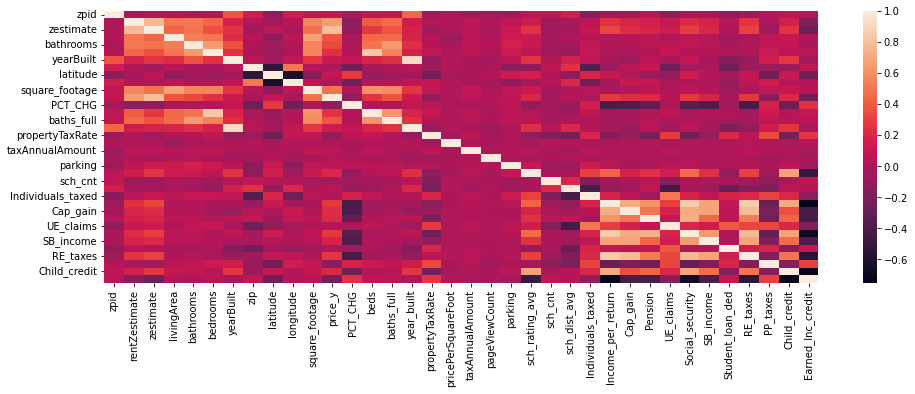

In [118]:
plt.figure(figsize = (16,5))
dataplot=sb.heatmap(df_zst.corr())
mp.show()

In [119]:
df_zst.taxAnnualAmount.isna().sum()/len(df_zst)

0.12110651274232194

## <font color='blue'> Add Cap Rates to the data
* Ensure property taxes are aligned with tax rate and property value
* Assuming that expenses are 20% (utilities, maintenance etc.)
* Cap Rate = (NOI - Expenses)/Price

In [120]:
df_zst[df_zst['taxAnnualAmount']<2000].shape

(1567, 51)

In [121]:
#df.loc[df["A"] > 3, "A"] = 10
df_zst.loc[df_zst['taxAnnualAmount'] < 2000, 'taxAnnualAmount'] = np.nan

In [122]:
df_zst.loc[df_zst['taxAnnualAmount'] > 12000, 'taxAnnualAmount'] = np.nan

In [123]:
df_zst.taxAnnualAmount.isna().sum()

2129

In [124]:
df_zst['taxAnnualAmount'].describe()

count     2462.000000
mean      3389.099106
std       1111.011318
min       2000.000000
25%       2545.000000
50%       3161.000000
75%       3947.500000
max      11053.000000
Name: taxAnnualAmount, dtype: float64

In [125]:
df_zst[['propertyTaxRate']] = df_zst[['propertyTaxRate']].fillna(value=0.98/100)

/var/folders/jr/_gd99zyd2gg8ks3xkxshk6240000gn/T/ipykernel_72664/2892268736.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_zst[['propertyTaxRate']] = df_zst[['propertyTaxRate']].fillna(value=0.98/100)


In [126]:
#df['Cat1'].fillna(df['Cat2'])
df_zst['taxAnnualAmount'] = df_zst['zestimate']*df_zst['propertyTaxRate']/100

/var/folders/jr/_gd99zyd2gg8ks3xkxshk6240000gn/T/ipykernel_72664/3416362677.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_zst['taxAnnualAmount'] = df_zst['zestimate']*df_zst['propertyTaxRate']/100


In [127]:
df_zst.head()

,zpid,rentZestimate,zestimate,livingArea,bathrooms,bedrooms,yearBuilt,address,city,state,zip,latitude,longitude,square_footage,price_y,PCT_CHG,census_county_name,beds,baths_full,year_built,propertyTaxRate,pricePerSquareFoot,propertyTypeDimension,taxAnnualAmount,dateSold,pageViewCount,hasAttachedProperty,poolFeatures,flooring,hasGarage,parking,hasWaterfrontView,lotSize,appliances,communityFeatures,propertyCondition,sch_rating_avg,sch_cnt,sch_dist_avg,Individuals_taxed,Income_per_return,Cap_gain,Pension,UE_claims,Social_security,SB_income,Student_loan_ded,RE_taxes,PP_taxes,Child_credit,Earned_Inc_credit
0,2.064281e+09,2187.90,349831.00,2103.0,2.0,4.0,2020.0,101 College Street,Kingsland,Georgia,31548,30.804209,-81.653325,2103.0,339900,0.117940,"Camden, GA",4.0,2.0,2020.0,0.98,162.0,Single Family,3428.34380,2022-05-31,0.0,False,NaN,"['Carpet', 'Tile']",True,2.0,NaN,0.45 Acres,"['Some Electric Appliances', 'Dishwasher', 'Di...","['Street Lights', 'Sidewalks', 'Walk to School']",NaN,7.333333,3.0,0.733333,20160.0,53.068519,6.500000,25.879817,3.546154,12.728319,36.895652,1.067021,3.122857,0.676744,2.125743,2.585463
1,9.103072e+07,2600.00,325200.00,2269.0,3.0,5.0,2004.0,169 School House Creek Drive,Saint Marys,Georgia,31558,30.767365,-81.588272,2269.0,310000,0.113899,"Camden, GA",5.0,3.0,2004.0,0.98,134.0,Single Family,3186.96000,2022-05-17,6.0,False,NaN,"['Carpet', 'Laminate', 'Vinyl']",True,0.0,NaN,"7,840 sqft","['Dishwasher', 'Oven/Range (Combo)', 'Refriger...","['Sidewalks', 'Street Lights']",Resale,7.666667,3.0,2.100000,18840.0,60.266882,17.274138,29.575630,3.477778,17.108497,46.670968,1.004819,4.105556,0.758537,2.175097,2.555497
2,1.112422e+08,1999.00,340500.00,1846.0,2.0,3.0,2004.0,1621 Sandpiper Court,Saint Marys,Georgia,31558,30.746731,-81.633995,1846.0,315000,0.113899,"Camden, GA",3.0,2.0,2004.0,0.98,173.0,Single Family,3336.90000,2022-05-13,20.0,False,['None'],['Tile'],True,2.0,NaN,"8,276 sqft","['Dryer', 'Dishwasher', 'Disposal', 'Microwave...","['Boat Facilities', 'Gated', 'Park', 'Street L...",NaN,7.666667,3.0,3.766667,18840.0,60.266882,17.274138,29.575630,3.477778,17.108497,46.670968,1.004819,4.105556,0.758537,2.175097,2.555497
3,2.090936e+09,1999.00,343686.00,1953.0,2.0,3.0,2018.0,346 Laurel Landing Boulevard,Kingsland,Georgia,31548,30.791878,-81.676750,1977.0,310000,0.117940,"Camden, GA",3.0,2.0,2017.0,0.98,NaN,Condo,3368.12280,NaN,0.0,False,NaN,NaN,False,0.0,NaN,NaN,NaN,NaN,NaN,8.000000,3.0,2.600000,20160.0,53.068519,6.500000,25.879817,3.546154,12.728319,36.895652,1.067021,3.122857,0.676744,2.125743,2.585463
4,2.064330e+09,1941.93,372880.05,1835.0,2.0,3.0,2022.0,81 Ossabaw Way,Waverly,Georgia,31565,31.104492,-81.604486,1835.0,369900,0.020674,"Camden, GA",3.0,2.0,2022.0,0.98,202.0,Single Family,3654.22449,2022-08-15,5.0,False,NaN,['Tile'],True,2.0,NaN,1.21 Acres,"['Dishwasher', 'Microwave', 'Oven/Range (Combo...","['Clubhouse', 'Gated', 'Golf', 'Lake', 'Fitnes...",New Construction,7.333333,3.0,16.200000,1800.0,66.877419,6.375000,32.572000,0.000000,17.610526,65.228571,1.160000,4.311111,0.400000,1.936000,2.294118


In [128]:
df_zst['taxAnnualAmount'].describe()

count     4591.000000
mean      4167.479810
std       1277.648639
min         28.020062
25%       3270.825000
50%       4034.510000
75%       4915.570000
max      16506.880000
Name: taxAnnualAmount, dtype: float64

In [129]:
df_zst.columns

Index(['zpid', 'rentZestimate', 'zestimate', 'livingArea', 'bathrooms',
       'bedrooms', 'yearBuilt', 'address', 'city', 'state', 'zip', 'latitude',
       'longitude', 'square_footage', 'price_y', 'PCT_CHG',
       'census_county_name', 'beds', 'baths_full', 'year_built',
       'propertyTaxRate', 'pricePerSquareFoot', 'propertyTypeDimension',
       'taxAnnualAmount', 'dateSold', 'pageViewCount', 'hasAttachedProperty',
       'poolFeatures', 'flooring', 'hasGarage', 'parking', 'hasWaterfrontView',
       'lotSize', 'appliances', 'communityFeatures', 'propertyCondition',
       'sch_rating_avg', 'sch_cnt', 'sch_dist_avg', 'Individuals_taxed',
       'Income_per_return', 'Cap_gain', 'Pension', 'UE_claims',
       'Social_security', 'SB_income', 'Student_loan_ded', 'RE_taxes',
       'PP_taxes', 'Child_credit', 'Earned_Inc_credit'],
      dtype='object')

In [130]:
df_zst[['address','zestimate','price_y']].corr()

,zestimate,price_y
zestimate,1.000000,0.789264
price_y,0.789264,1.000000


In [131]:
df_zst[['taxAnnualAmount','rentZestimate']].isna().sum()

taxAnnualAmount    0
rentZestimate      0
dtype: int64

In [132]:
df_zst['NOI'] = df_zst['rentZestimate']*12 

/var/folders/jr/_gd99zyd2gg8ks3xkxshk6240000gn/T/ipykernel_72664/1471401341.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_zst['NOI'] = df_zst['rentZestimate']*12


In [133]:
df_zst['Expenses'] = df_zst['NOI']*0.2 + df_zst['taxAnnualAmount']

/var/folders/jr/_gd99zyd2gg8ks3xkxshk6240000gn/T/ipykernel_72664/1164920707.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_zst['Expenses'] = df_zst['NOI']*0.2 + df_zst['taxAnnualAmount']


In [134]:
df_zst[['NOI','Expenses']]

,NOI,Expenses
0,26254.80,8679.30380
1,31200.00,9426.96000
2,23988.00,8134.50000
3,23988.00,8165.72280
4,23303.16,8314.85649
...,...,...
4586,22800.00,9533.70000
4587,24588.00,9048.78000
4588,43188.00,13174.97140
4589,43188.00,12529.24000


In [135]:
df_zst['cap_rate'] = (df_zst['NOI'] - df_zst['Expenses'])/df_zst['price_y']

/var/folders/jr/_gd99zyd2gg8ks3xkxshk6240000gn/T/ipykernel_72664/1423541546.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_zst['cap_rate'] = (df_zst['NOI'] - df_zst['Expenses'])/df_zst['price_y']


In [136]:
df_zst.head()

,zpid,rentZestimate,zestimate,livingArea,bathrooms,bedrooms,yearBuilt,address,city,state,zip,latitude,longitude,square_footage,price_y,PCT_CHG,census_county_name,beds,baths_full,year_built,propertyTaxRate,pricePerSquareFoot,propertyTypeDimension,taxAnnualAmount,dateSold,pageViewCount,hasAttachedProperty,poolFeatures,flooring,hasGarage,parking,hasWaterfrontView,lotSize,appliances,communityFeatures,propertyCondition,sch_rating_avg,sch_cnt,sch_dist_avg,Individuals_taxed,Income_per_return,Cap_gain,Pension,UE_claims,Social_security,SB_income,Student_loan_ded,RE_taxes,PP_taxes,Child_credit,Earned_Inc_credit,NOI,Expenses,cap_rate
0,2.064281e+09,2187.90,349831.00,2103.0,2.0,4.0,2020.0,101 College Street,Kingsland,Georgia,31548,30.804209,-81.653325,2103.0,339900,0.117940,"Camden, GA",4.0,2.0,2020.0,0.98,162.0,Single Family,3428.34380,2022-05-31,0.0,False,NaN,"['Carpet', 'Tile']",True,2.0,NaN,0.45 Acres,"['Some Electric Appliances', 'Dishwasher', 'Di...","['Street Lights', 'Sidewalks', 'Walk to School']",NaN,7.333333,3.0,0.733333,20160.0,53.068519,6.500000,25.879817,3.546154,12.728319,36.895652,1.067021,3.122857,0.676744,2.125743,2.585463,26254.80,8679.30380,0.051708
1,9.103072e+07,2600.00,325200.00,2269.0,3.0,5.0,2004.0,169 School House Creek Drive,Saint Marys,Georgia,31558,30.767365,-81.588272,2269.0,310000,0.113899,"Camden, GA",5.0,3.0,2004.0,0.98,134.0,Single Family,3186.96000,2022-05-17,6.0,False,NaN,"['Carpet', 'Laminate', 'Vinyl']",True,0.0,NaN,"7,840 sqft","['Dishwasher', 'Oven/Range (Combo)', 'Refriger...","['Sidewalks', 'Street Lights']",Resale,7.666667,3.0,2.100000,18840.0,60.266882,17.274138,29.575630,3.477778,17.108497,46.670968,1.004819,4.105556,0.758537,2.175097,2.555497,31200.00,9426.96000,0.070236
2,1.112422e+08,1999.00,340500.00,1846.0,2.0,3.0,2004.0,1621 Sandpiper Court,Saint Marys,Georgia,31558,30.746731,-81.633995,1846.0,315000,0.113899,"Camden, GA",3.0,2.0,2004.0,0.98,173.0,Single Family,3336.90000,2022-05-13,20.0,False,['None'],['Tile'],True,2.0,NaN,"8,276 sqft","['Dryer', 'Dishwasher', 'Disposal', 'Microwave...","['Boat Facilities', 'Gated', 'Park', 'Street L...",NaN,7.666667,3.0,3.766667,18840.0,60.266882,17.274138,29.575630,3.477778,17.108497,46.670968,1.004819,4.105556,0.758537,2.175097,2.555497,23988.00,8134.50000,0.050329
3,2.090936e+09,1999.00,343686.00,1953.0,2.0,3.0,2018.0,346 Laurel Landing Boulevard,Kingsland,Georgia,31548,30.791878,-81.676750,1977.0,310000,0.117940,"Camden, GA",3.0,2.0,2017.0,0.98,NaN,Condo,3368.12280,NaN,0.0,False,NaN,NaN,False,0.0,NaN,NaN,NaN,NaN,NaN,8.000000,3.0,2.600000,20160.0,53.068519,6.500000,25.879817,3.546154,12.728319,36.895652,1.067021,3.122857,0.676744,2.125743,2.585463,23988.00,8165.72280,0.051040
4,2.064330e+09,1941.93,372880.05,1835.0,2.0,3.0,2022.0,81 Ossabaw Way,Waverly,Georgia,31565,31.104492,-81.604486,1835.0,369900,0.020674,"Camden, GA",3.0,2.0,2022.0,0.98,202.0,Single Family,3654.22449,2022-08-15,5.0,False,NaN,['Tile'],True,2.0,NaN,1.21 Acres,"['Dishwasher', 'Microwave', 'Oven/Range (Combo...","['Clubhouse', 'Gated', 'Golf', 'Lake', 'Fitnes...",New Construction,7.333333,3.0,16.200000,1800.0,66.877419,6.375000,32.572000,0.000000,17.610526,65.228571,1.160000,4.311111,0.400000,1.936000,2.294118,23303.16,8314.85649,0.040520


In [137]:
df_zst['total_appliances'] = df_zst.appliances.str.replace("'","").str.count(',')+1

/var/folders/jr/_gd99zyd2gg8ks3xkxshk6240000gn/T/ipykernel_72664/1451311757.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_zst['total_appliances'] = df_zst.appliances.str.replace("'","").str.count(',')+1


In [138]:
df_zst['total_community_feat'] = df_zst.communityFeatures.str.replace("'","").str.count(',')+1

/var/folders/jr/_gd99zyd2gg8ks3xkxshk6240000gn/T/ipykernel_72664/1165972908.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_zst['total_community_feat'] = df_zst.communityFeatures.str.replace("'","").str.count(',')+1


In [139]:
df_zst.to_csv('clean_data_zil_tax.csv')

### <font color = 'blue'> Creating a Category of Type of Property - New, Remodeled or Resale
The idea is that good deals might be hiding in resale or remodeled?

In [140]:
df_zst.propertyCondition.value_counts()

Resale                                             2611
New Construction                                    513
Updated/Remodeled                                   249
Under Construction                                  174
To Be Built                                          52
Fixer                                                44
New Construction,Under Construction                  15
Updated/Remodeled,Resale                              6
50+ Years                                             3
Completed                                             2
Pre Construction                                      2
ReSale                                                1
New Construction,To Be Built,Under Construction       1
Fixer,Updated/Remodeled                               1
30+ Years                                             1
Name: propertyCondition, dtype: int64

In [141]:
df_zst['Prop_Cond_Grp'] = np.where(df_zst['propertyCondition'].isin(['New Construction', 
                                              'Under Construction',
                                              'To Be Built',
                                             'New Construction,Under Construction',
                                              'Completed',
                                              'Pre Construction',
                                              'New Construction,To Be Built,Under Construction',                                           
                                             ]), 'New',
                                             np.where(df_zst['propertyCondition'].isin(['Updated/Remodeled', 
                                              'Updated/Remodeled,Resale',
                                              'Fixer,Updated/Remodeled']), 'Remodeled', 'Resale'))
                   
                   #np.where(df['col2']<15, 'value3', 'value4')))

/var/folders/jr/_gd99zyd2gg8ks3xkxshk6240000gn/T/ipykernel_72664/2637560585.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_zst['Prop_Cond_Grp'] = np.where(df_zst['propertyCondition'].isin(['New Construction',


In [142]:
df_zst.Prop_Cond_Grp.value_counts()

Resale       3576
New           759
Remodeled     256
Name: Prop_Cond_Grp, dtype: int64

In [143]:
df_zst.head()

,zpid,rentZestimate,zestimate,livingArea,bathrooms,bedrooms,yearBuilt,address,city,state,zip,latitude,longitude,square_footage,price_y,PCT_CHG,census_county_name,beds,baths_full,year_built,propertyTaxRate,pricePerSquareFoot,propertyTypeDimension,taxAnnualAmount,dateSold,pageViewCount,hasAttachedProperty,poolFeatures,flooring,hasGarage,parking,hasWaterfrontView,lotSize,appliances,communityFeatures,propertyCondition,sch_rating_avg,sch_cnt,sch_dist_avg,Individuals_taxed,Income_per_return,Cap_gain,Pension,UE_claims,Social_security,SB_income,Student_loan_ded,RE_taxes,PP_taxes,Child_credit,Earned_Inc_credit,NOI,Expenses,cap_rate,total_appliances,total_community_feat,Prop_Cond_Grp
0,2.064281e+09,2187.90,349831.00,2103.0,2.0,4.0,2020.0,101 College Street,Kingsland,Georgia,31548,30.804209,-81.653325,2103.0,339900,0.117940,"Camden, GA",4.0,2.0,2020.0,0.98,162.0,Single Family,3428.34380,2022-05-31,0.0,False,NaN,"['Carpet', 'Tile']",True,2.0,NaN,0.45 Acres,"['Some Electric Appliances', 'Dishwasher', 'Di...","['Street Lights', 'Sidewalks', 'Walk to School']",NaN,7.333333,3.0,0.733333,20160.0,53.068519,6.500000,25.879817,3.546154,12.728319,36.895652,1.067021,3.122857,0.676744,2.125743,2.585463,26254.80,8679.30380,0.051708,7.0,3.0,Resale
1,9.103072e+07,2600.00,325200.00,2269.0,3.0,5.0,2004.0,169 School House Creek Drive,Saint Marys,Georgia,31558,30.767365,-81.588272,2269.0,310000,0.113899,"Camden, GA",5.0,3.0,2004.0,0.98,134.0,Single Family,3186.96000,2022-05-17,6.0,False,NaN,"['Carpet', 'Laminate', 'Vinyl']",True,0.0,NaN,"7,840 sqft","['Dishwasher', 'Oven/Range (Combo)', 'Refriger...","['Sidewalks', 'Street Lights']",Resale,7.666667,3.0,2.100000,18840.0,60.266882,17.274138,29.575630,3.477778,17.108497,46.670968,1.004819,4.105556,0.758537,2.175097,2.555497,31200.00,9426.96000,0.070236,4.0,2.0,Resale
2,1.112422e+08,1999.00,340500.00,1846.0,2.0,3.0,2004.0,1621 Sandpiper Court,Saint Marys,Georgia,31558,30.746731,-81.633995,1846.0,315000,0.113899,"Camden, GA",3.0,2.0,2004.0,0.98,173.0,Single Family,3336.90000,2022-05-13,20.0,False,['None'],['Tile'],True,2.0,NaN,"8,276 sqft","['Dryer', 'Dishwasher', 'Disposal', 'Microwave...","['Boat Facilities', 'Gated', 'Park', 'Street L...",NaN,7.666667,3.0,3.766667,18840.0,60.266882,17.274138,29.575630,3.477778,17.108497,46.670968,1.004819,4.105556,0.758537,2.175097,2.555497,23988.00,8134.50000,0.050329,10.0,6.0,Resale
3,2.090936e+09,1999.00,343686.00,1953.0,2.0,3.0,2018.0,346 Laurel Landing Boulevard,Kingsland,Georgia,31548,30.791878,-81.676750,1977.0,310000,0.117940,"Camden, GA",3.0,2.0,2017.0,0.98,NaN,Condo,3368.12280,NaN,0.0,False,NaN,NaN,False,0.0,NaN,NaN,NaN,NaN,NaN,8.000000,3.0,2.600000,20160.0,53.068519,6.500000,25.879817,3.546154,12.728319,36.895652,1.067021,3.122857,0.676744,2.125743,2.585463,23988.00,8165.72280,0.051040,NaN,NaN,Resale
4,2.064330e+09,1941.93,372880.05,1835.0,2.0,3.0,2022.0,81 Ossabaw Way,Waverly,Georgia,31565,31.104492,-81.604486,1835.0,369900,0.020674,"Camden, GA",3.0,2.0,2022.0,0.98,202.0,Single Family,3654.22449,2022-08-15,5.0,False,NaN,['Tile'],True,2.0,NaN,1.21 Acres,"['Dishwasher', 'Microwave', 'Oven/Range (Combo...","['Clubhouse', 'Gated', 'Golf', 'Lake', 'Fitnes...",New Construction,7.333333,3.0,16.200000,1800.0,66.877419,6.375000,32.572000,0.000000,17.610526,65.228571,1.160000,4.311111,0.400000,1.936000,2.294118,23303.16,8314.85649,0.040520,4.0,7.0,New


In [144]:
df_zst.lotSize.isna().sum()

325

### <font color = 'blue'> The LOT Size can make the property very attractive, here we convert Acres to Square Feet and then impute missing values using an average conversaion factor

In [145]:
#0.45 Acres
df_zst[['Lvalue','Lunits']] = df_zst['lotSize'].str.split(' ',expand=True)


/var/folders/jr/_gd99zyd2gg8ks3xkxshk6240000gn/T/ipykernel_72664/2107355821.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_zst[['Lvalue','Lunits']] = df_zst['lotSize'].str.split(' ',expand=True)
/var/folders/jr/_gd99zyd2gg8ks3xkxshk6240000gn/T/ipykernel_72664/2107355821.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_zst[['Lvalue','Lunits']] = df_zst['lotSize'].str.split(' ',expand=True)


In [146]:
df_zst.head()

,zpid,rentZestimate,zestimate,livingArea,bathrooms,bedrooms,yearBuilt,address,city,state,zip,latitude,longitude,square_footage,price_y,PCT_CHG,census_county_name,beds,baths_full,year_built,propertyTaxRate,pricePerSquareFoot,propertyTypeDimension,taxAnnualAmount,dateSold,pageViewCount,hasAttachedProperty,poolFeatures,flooring,hasGarage,parking,hasWaterfrontView,lotSize,appliances,communityFeatures,propertyCondition,sch_rating_avg,sch_cnt,sch_dist_avg,Individuals_taxed,Income_per_return,Cap_gain,Pension,UE_claims,Social_security,SB_income,Student_loan_ded,RE_taxes,PP_taxes,Child_credit,Earned_Inc_credit,NOI,Expenses,cap_rate,total_appliances,total_community_feat,Prop_Cond_Grp,Lvalue,Lunits
0,2.064281e+09,2187.90,349831.00,2103.0,2.0,4.0,2020.0,101 College Street,Kingsland,Georgia,31548,30.804209,-81.653325,2103.0,339900,0.117940,"Camden, GA",4.0,2.0,2020.0,0.98,162.0,Single Family,3428.34380,2022-05-31,0.0,False,NaN,"['Carpet', 'Tile']",True,2.0,NaN,0.45 Acres,"['Some Electric Appliances', 'Dishwasher', 'Di...","['Street Lights', 'Sidewalks', 'Walk to School']",NaN,7.333333,3.0,0.733333,20160.0,53.068519,6.500000,25.879817,3.546154,12.728319,36.895652,1.067021,3.122857,0.676744,2.125743,2.585463,26254.80,8679.30380,0.051708,7.0,3.0,Resale,0.45,Acres
1,9.103072e+07,2600.00,325200.00,2269.0,3.0,5.0,2004.0,169 School House Creek Drive,Saint Marys,Georgia,31558,30.767365,-81.588272,2269.0,310000,0.113899,"Camden, GA",5.0,3.0,2004.0,0.98,134.0,Single Family,3186.96000,2022-05-17,6.0,False,NaN,"['Carpet', 'Laminate', 'Vinyl']",True,0.0,NaN,"7,840 sqft","['Dishwasher', 'Oven/Range (Combo)', 'Refriger...","['Sidewalks', 'Street Lights']",Resale,7.666667,3.0,2.100000,18840.0,60.266882,17.274138,29.575630,3.477778,17.108497,46.670968,1.004819,4.105556,0.758537,2.175097,2.555497,31200.00,9426.96000,0.070236,4.0,2.0,Resale,"7,840",sqft
2,1.112422e+08,1999.00,340500.00,1846.0,2.0,3.0,2004.0,1621 Sandpiper Court,Saint Marys,Georgia,31558,30.746731,-81.633995,1846.0,315000,0.113899,"Camden, GA",3.0,2.0,2004.0,0.98,173.0,Single Family,3336.90000,2022-05-13,20.0,False,['None'],['Tile'],True,2.0,NaN,"8,276 sqft","['Dryer', 'Dishwasher', 'Disposal', 'Microwave...","['Boat Facilities', 'Gated', 'Park', 'Street L...",NaN,7.666667,3.0,3.766667,18840.0,60.266882,17.274138,29.575630,3.477778,17.108497,46.670968,1.004819,4.105556,0.758537,2.175097,2.555497,23988.00,8134.50000,0.050329,10.0,6.0,Resale,"8,276",sqft
3,2.090936e+09,1999.00,343686.00,1953.0,2.0,3.0,2018.0,346 Laurel Landing Boulevard,Kingsland,Georgia,31548,30.791878,-81.676750,1977.0,310000,0.117940,"Camden, GA",3.0,2.0,2017.0,0.98,NaN,Condo,3368.12280,NaN,0.0,False,NaN,NaN,False,0.0,NaN,NaN,NaN,NaN,NaN,8.000000,3.0,2.600000,20160.0,53.068519,6.500000,25.879817,3.546154,12.728319,36.895652,1.067021,3.122857,0.676744,2.125743,2.585463,23988.00,8165.72280,0.051040,NaN,NaN,Resale,NaN,NaN
4,2.064330e+09,1941.93,372880.05,1835.0,2.0,3.0,2022.0,81 Ossabaw Way,Waverly,Georgia,31565,31.104492,-81.604486,1835.0,369900,0.020674,"Camden, GA",3.0,2.0,2022.0,0.98,202.0,Single Family,3654.22449,2022-08-15,5.0,False,NaN,['Tile'],True,2.0,NaN,1.21 Acres,"['Dishwasher', 'Microwave', 'Oven/Range (Combo...","['Clubhouse', 'Gated', 'Golf', 'Lake', 'Fitnes...",New Construction,7.333333,3.0,16.200000,1800.0,66.877419,6.375000,32.572000,0.000000,17.610526,65.228571,1.160000,4.311111,0.400000,1.936000,2.294118,23303.16,8314.85649,0.040520,4.0,7.0,New,1.21,Acres


In [147]:
df_zst.Lvalue.isna().sum()

325

In [148]:
df_zst.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4591 entries, 0 to 4590
Data columns (total 59 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   zpid                   4591 non-null   float64
 1   rentZestimate          4591 non-null   float64
 2   zestimate              4591 non-null   float64
 3   livingArea             4591 non-null   float64
 4   bathrooms              4591 non-null   float64
 5   bedrooms               4591 non-null   float64
 6   yearBuilt              4591 non-null   float64
 7   address                4591 non-null   object 
 8   city                   4591 non-null   object 
 9   state                  4591 non-null   object 
 10  zip                    4591 non-null   int64  
 11  latitude               4591 non-null   float64
 12  longitude              4591 non-null   float64
 13  square_footage         4591 non-null   float64
 14  price_y                4591 non-null   int64  
 15  PCT_

In [149]:
df_zst['Lvalue'] = df_zst['Lvalue'].str.replace(r',', '').astype(float)
#s2 = s1.astype('int64', copy=False)


/var/folders/jr/_gd99zyd2gg8ks3xkxshk6240000gn/T/ipykernel_72664/961055840.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_zst['Lvalue'] = df_zst['Lvalue'].str.replace(r',', '').astype(float)


In [150]:
df_zst['Lot_Size_SqFt'] = np.where(df_zst['Lunits'] == 'Acres',
                                               df_zst['Lvalue'] * 43560,
                                               df_zst['Lvalue'])


/var/folders/jr/_gd99zyd2gg8ks3xkxshk6240000gn/T/ipykernel_72664/786083135.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_zst['Lot_Size_SqFt'] = np.where(df_zst['Lunits'] == 'Acres',


In [151]:
con_fact = np.mean(df_zst['livingArea']/df_zst['Lot_Size_SqFt'])

In [152]:
df_zst['Lot_Size_SqFt'] = df_zst['Lot_Size_SqFt'].fillna(df_zst['livingArea']/con_fact)

/var/folders/jr/_gd99zyd2gg8ks3xkxshk6240000gn/T/ipykernel_72664/76934979.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_zst['Lot_Size_SqFt'] = df_zst['Lot_Size_SqFt'].fillna(df_zst['livingArea']/con_fact)


In [153]:
df_zst.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4591 entries, 0 to 4590
Data columns (total 60 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   zpid                   4591 non-null   float64
 1   rentZestimate          4591 non-null   float64
 2   zestimate              4591 non-null   float64
 3   livingArea             4591 non-null   float64
 4   bathrooms              4591 non-null   float64
 5   bedrooms               4591 non-null   float64
 6   yearBuilt              4591 non-null   float64
 7   address                4591 non-null   object 
 8   city                   4591 non-null   object 
 9   state                  4591 non-null   object 
 10  zip                    4591 non-null   int64  
 11  latitude               4591 non-null   float64
 12  longitude              4591 non-null   float64
 13  square_footage         4591 non-null   float64
 14  price_y                4591 non-null   int64  
 15  PCT_

In [154]:
df_zst.columns

Index(['zpid', 'rentZestimate', 'zestimate', 'livingArea', 'bathrooms',
       'bedrooms', 'yearBuilt', 'address', 'city', 'state', 'zip', 'latitude',
       'longitude', 'square_footage', 'price_y', 'PCT_CHG',
       'census_county_name', 'beds', 'baths_full', 'year_built',
       'propertyTaxRate', 'pricePerSquareFoot', 'propertyTypeDimension',
       'taxAnnualAmount', 'dateSold', 'pageViewCount', 'hasAttachedProperty',
       'poolFeatures', 'flooring', 'hasGarage', 'parking', 'hasWaterfrontView',
       'lotSize', 'appliances', 'communityFeatures', 'propertyCondition',
       'sch_rating_avg', 'sch_cnt', 'sch_dist_avg', 'Individuals_taxed',
       'Income_per_return', 'Cap_gain', 'Pension', 'UE_claims',
       'Social_security', 'SB_income', 'Student_loan_ded', 'RE_taxes',
       'PP_taxes', 'Child_credit', 'Earned_Inc_credit', 'NOI', 'Expenses',
       'cap_rate', 'total_appliances', 'total_community_feat', 'Prop_Cond_Grp',
       'Lvalue', 'Lunits', 'Lot_Size_SqFt'],
      dtype

In [155]:
df_c = df_zst[['zpid', 'rentZestimate', 'zestimate', 'livingArea', 'bathrooms',
       'bedrooms', 'yearBuilt', 'square_footage', 'price_y', 'PCT_CHG', 'pricePerSquareFoot',
       'taxAnnualAmount', 'pageViewCount','Lot_Size_SqFt',
       'hasAttachedProperty', 'poolFeatures', 'flooring', 'hasGarage',
       'parking', 'hasWaterfrontView', 'total_appliances','total_community_feat','Prop_Cond_Grp',
       'sch_rating_avg', 'sch_cnt',
       'sch_dist_avg', 'Individuals_taxed', 'Income_per_return', 'Cap_gain',
       'Pension', 'UE_claims', 'Social_security', 'SB_income',
       'Student_loan_ded', 'RE_taxes', 'PP_taxes', 'Child_credit',
       'Earned_Inc_credit', 'cap_rate']]

In [156]:
df_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4591 entries, 0 to 4590
Data columns (total 39 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   zpid                  4591 non-null   float64
 1   rentZestimate         4591 non-null   float64
 2   zestimate             4591 non-null   float64
 3   livingArea            4591 non-null   float64
 4   bathrooms             4591 non-null   float64
 5   bedrooms              4591 non-null   float64
 6   yearBuilt             4591 non-null   float64
 7   square_footage        4591 non-null   float64
 8   price_y               4591 non-null   int64  
 9   PCT_CHG               4591 non-null   float64
 10  pricePerSquareFoot    4126 non-null   float64
 11  taxAnnualAmount       4591 non-null   float64
 12  pageViewCount         4587 non-null   float64
 13  Lot_Size_SqFt         4591 non-null   float64
 14  hasAttachedProperty   4588 non-null   object 
 15  poolFeatures         

In [157]:
df_c.hasWaterfrontView.value_counts()

True    479
Name: hasWaterfrontView, dtype: int64

In [158]:
df_c['Water_View'] = np.where(df_c['hasWaterfrontView'] == 'True',1,0)

/var/folders/jr/_gd99zyd2gg8ks3xkxshk6240000gn/T/ipykernel_72664/3856466764.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_c['Water_View'] = np.where(df_c['hasWaterfrontView'] == 'True',1,0)


In [159]:
df_c.hasAttachedProperty.value_counts()

False    4562
True       26
Name: hasAttachedProperty, dtype: int64

<font color='red'> Limited value due to 26 records, will be deleted

In [160]:
df_c.hasGarage.value_counts()

True     3018
False    1570
Name: hasGarage, dtype: int64

In [161]:
df_c['Two_Car_Garage'] = np.where((df_c['hasGarage'] == True) & (df_c['parking'] >1) ,1,0)

#df_c[(df_c['hasGarage'] == True) & (df_c['parking'] >1)]
#dfObj[(dfObj['Sale'] > 30) & (dfObj['Sale'] < 33) ]

/var/folders/jr/_gd99zyd2gg8ks3xkxshk6240000gn/T/ipykernel_72664/591284635.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_c['Two_Car_Garage'] = np.where((df_c['hasGarage'] == True) & (df_c['parking'] >1) ,1,0)


In [162]:
df_c.head()

,zpid,rentZestimate,zestimate,livingArea,bathrooms,bedrooms,yearBuilt,square_footage,price_y,PCT_CHG,pricePerSquareFoot,taxAnnualAmount,pageViewCount,Lot_Size_SqFt,hasAttachedProperty,poolFeatures,flooring,hasGarage,parking,hasWaterfrontView,total_appliances,total_community_feat,Prop_Cond_Grp,sch_rating_avg,sch_cnt,sch_dist_avg,Individuals_taxed,Income_per_return,Cap_gain,Pension,UE_claims,Social_security,SB_income,Student_loan_ded,RE_taxes,PP_taxes,Child_credit,Earned_Inc_credit,cap_rate,Water_View,Two_Car_Garage
0,2.064281e+09,2187.90,349831.00,2103.0,2.0,4.0,2020.0,2103.0,339900,0.117940,162.0,3428.34380,0.0,19602.000000,False,NaN,"['Carpet', 'Tile']",True,2.0,NaN,7.0,3.0,Resale,7.333333,3.0,0.733333,20160.0,53.068519,6.500000,25.879817,3.546154,12.728319,36.895652,1.067021,3.122857,0.676744,2.125743,2.585463,0.051708,0,1
1,9.103072e+07,2600.00,325200.00,2269.0,3.0,5.0,2004.0,2269.0,310000,0.113899,134.0,3186.96000,6.0,7840.000000,False,NaN,"['Carpet', 'Laminate', 'Vinyl']",True,0.0,NaN,4.0,2.0,Resale,7.666667,3.0,2.100000,18840.0,60.266882,17.274138,29.575630,3.477778,17.108497,46.670968,1.004819,4.105556,0.758537,2.175097,2.555497,0.070236,0,0
2,1.112422e+08,1999.00,340500.00,1846.0,2.0,3.0,2004.0,1846.0,315000,0.113899,173.0,3336.90000,20.0,8276.000000,False,['None'],['Tile'],True,2.0,NaN,10.0,6.0,Resale,7.666667,3.0,3.766667,18840.0,60.266882,17.274138,29.575630,3.477778,17.108497,46.670968,1.004819,4.105556,0.758537,2.175097,2.555497,0.050329,0,1
3,2.090936e+09,1999.00,343686.00,1953.0,2.0,3.0,2018.0,1977.0,310000,0.117940,NaN,3368.12280,0.0,4008.477537,False,NaN,NaN,False,0.0,NaN,NaN,NaN,Resale,8.000000,3.0,2.600000,20160.0,53.068519,6.500000,25.879817,3.546154,12.728319,36.895652,1.067021,3.122857,0.676744,2.125743,2.585463,0.051040,0,0
4,2.064330e+09,1941.93,372880.05,1835.0,2.0,3.0,2022.0,1835.0,369900,0.020674,202.0,3654.22449,5.0,52707.600000,False,NaN,['Tile'],True,2.0,NaN,4.0,7.0,New,7.333333,3.0,16.200000,1800.0,66.877419,6.375000,32.572000,0.000000,17.610526,65.228571,1.160000,4.311111,0.400000,1.936000,2.294118,0.040520,0,1


In [163]:
df_c.poolFeatures.value_counts()

['None']                                            1315
['In Ground']                                         90
['Community']                                         63
['Above Ground']                                      33
['In Ground', 'Salt Water']                           15
['Pool/Spa Combo']                                    10
['In Ground', 'Vinyl']                                 8
['Association']                                        8
['Heated', 'In Ground']                                4
['Gunite', 'In Ground']                                3
['Pool/Spa Combo', 'In Ground', 'Salt Water']          2
['Heated']                                             2
['Indoor']                                             2
['Salt Water']                                         2
['Concrete']                                           1
['Screen Enclosure']                                   1
['Outdoor Pool']                                       1
['Pool/Spa Combo', 'Screen Encl

In [164]:
df_c['poolFeatures']=="['None']"

0       False
1       False
2        True
3       False
4       False
        ...  
4586    False
4587    False
4588    False
4589    False
4590    False
Name: poolFeatures, Length: 4591, dtype: bool

In [165]:
df_c['HasPool'] = np.where(df_c['poolFeatures'].isin(["[In Ground]", "['Above Ground']", 
                                                      "['In Ground', 'Salt Water']",
                                 "['Pool/Spa Combo']","['In Ground', 'Vinyl']","['Heated', 'In Ground']",
                                 "['Gunite', 'In Ground']" ,"['Pool/Spa Combo', 'In Ground', 'Salt Water']",
                                 "['Heated']",
                                 "['Indoor']","['Salt Water']","['Concrete']","['Screen Enclosure']",
                                 "['Outdoor Pool']","['Pool/Spa Combo', 'Screen Enclosure', 'Heated']",
                                 "['Pool/Spa Combo', 'In Ground']",
                                 "['Heated', 'In Ground', 'Vinyl']",
                                 "['Heated', 'Pool/Spa Combo', 'In Ground']",
                                 "['In Ground', 'Heated', 'Salt Water']",
                                 "['Vinyl']",
                                 "['Screen Enclosure', 'In Ground', 'Salt Water']",
                                 "['Pool/Spa Combo', 'Above Ground']"]),1,0)

/var/folders/jr/_gd99zyd2gg8ks3xkxshk6240000gn/T/ipykernel_72664/1805479917.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_c['HasPool'] = np.where(df_c['poolFeatures'].isin(["[In Ground]", "['Above Ground']",


In [166]:
df_c.HasPool.value_counts()

0    4499
1      92
Name: HasPool, dtype: int64

In [167]:
df_c.flooring.value_counts()

['Hardwood']                                              457
['Hardwood', 'Tile', 'Carpet']                            333
['Carpet']                                                242
['Carpet', 'Ceramic Tile', 'Hardwood']                    236
['Carpet', 'Hardwood']                                    203
                                                         ... 
['Carpet', 'Laminate', 'Other', 'Vinyl']                    1
['Other', 'Sustainable']                                    1
['Hardwood', 'Laminate', 'Other', 'Vinyl']                  1
['Softwood', 'Tile', 'Carpet', 'Concrete', 'Hardwood']      1
['Carpet', 'Hardwood Engineered', 'Tile']                   1
Name: flooring, Length: 212, dtype: int64

In [168]:
#df_c[df_c['flooring'].str.contains("Hardwood")]
df_c[df_c['flooring'].str.contains("Hardwood")==True]

,zpid,rentZestimate,zestimate,livingArea,bathrooms,bedrooms,yearBuilt,square_footage,price_y,PCT_CHG,pricePerSquareFoot,taxAnnualAmount,pageViewCount,Lot_Size_SqFt,hasAttachedProperty,poolFeatures,flooring,hasGarage,parking,hasWaterfrontView,total_appliances,total_community_feat,Prop_Cond_Grp,sch_rating_avg,sch_cnt,sch_dist_avg,Individuals_taxed,Income_per_return,Cap_gain,Pension,UE_claims,Social_security,SB_income,Student_loan_ded,RE_taxes,PP_taxes,Child_credit,Earned_Inc_credit,cap_rate,Water_View,Two_Car_Garage,HasPool
9,7.637437e+07,3751.00,603000.00,2224.0,3.0,3.0,1997.0,2224.0,599900,0.148750,257.0,5909.400000,6.0,1.354716e+05,False,NaN,"['Hardwood', 'Carpet']",True,0.0,NaN,7.0,1.0,Resale,7.333333,3.0,4.133333,4720.0,60.546725,6.444000,30.132787,0.000000,13.681579,35.262500,1.050000,3.466667,0.569231,2.120896,2.685417,0.050175,0,0,0
14,1.112465e+08,3450.00,553500.00,4698.0,5.0,6.0,2002.0,4698.0,595000,0.117940,112.0,5424.300000,12.0,1.306800e+05,False,['None'],"['Carpet', 'Hardwood', 'Tile']",True,2.0,NaN,9.0,1.0,Resale,7.333333,3.0,2.666667,20160.0,53.068519,6.500000,25.879817,3.546154,12.728319,36.895652,1.067021,3.122857,0.676744,2.125743,2.585463,0.046547,0,1,0
15,9.103345e+07,3031.74,486031.59,2784.0,2.0,3.0,2004.0,2784.0,549900,0.138411,185.0,4763.109582,707.0,1.472328e+05,False,NaN,"['Carpet', 'Hardwood', 'Tile']",True,6.0,NaN,5.0,NaN,Resale,7.333333,3.0,14.100000,840.0,57.754762,4.533333,25.054545,0.000000,14.628571,0.000000,1.266667,2.625000,0.566667,1.891667,2.577778,0.044265,0,1,0
17,7.637593e+07,2799.00,392000.00,2044.0,3.0,3.0,1970.0,2044.0,386250,0.113899,182.0,3841.600000,11.0,4.195252e+03,False,['None'],"['Carpet', 'Hardwood', 'Tile']",True,1.0,NaN,7.0,3.0,Resale,8.000000,3.0,3.866667,18840.0,60.266882,17.274138,29.575630,3.477778,17.108497,46.670968,1.004819,4.105556,0.758537,2.175097,2.555497,0.059621,0,0,0
18,7.637529e+07,2799.00,395500.00,2334.0,2.0,4.0,1968.0,2534.0,400000,0.113899,169.0,3875.900000,4.0,2.482920e+04,False,NaN,"['Tile', 'Hardwood']",False,3.0,NaN,4.0,NaN,Resale,8.000000,3.0,3.200000,18840.0,60.266882,17.274138,29.575630,3.477778,17.108497,46.670968,1.004819,4.105556,0.758537,2.175097,2.555497,0.057486,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4584,2.072128e+09,3999.00,382712.80,0.0,4.0,9.0,1890.0,4708.0,389900,0.142056,NaN,2793.803440,10.0,9.147000e+03,False,NaN,['Hardwood'],False,0.0,NaN,1.0,1.0,Resale,5.666667,3.0,1.200000,22710.0,65.436922,26.726316,25.134247,1.002532,18.423022,86.184507,1.088333,4.124390,0.468750,1.813333,2.651351,0.091297,0,0,0
4586,1.108403e+08,1900.00,421500.00,2000.0,2.0,3.0,2004.0,2000.0,399900,0.138411,200.0,4973.700000,14.0,2.526480e+06,False,NaN,['Hardwood'],False,0.0,True,2.0,1.0,Resale,4.666667,4.0,12.900000,1410.0,51.947945,25.928571,27.716667,1.933333,14.238462,24.333333,1.233333,4.200000,0.000000,1.494118,2.323810,0.033174,0,0,0
4587,7.661808e+07,2049.00,350100.00,4003.0,4.0,4.0,1817.0,4003.0,350000,0.080789,84.0,4131.180000,13.0,2.221560e+04,False,NaN,"['Hardwood', 'Wood']",False,2.0,NaN,4.0,1.0,Resale,4.666667,4.0,1.433333,5830.0,46.903987,18.375862,26.596923,3.200000,14.224528,30.950000,1.173333,3.646667,0.400000,1.528947,3.019565,0.044398,0,0,0
4588,7.661809e+07,3599.00,384523.00,3808.0,4.0,5.0,1828.0,3808.0,499900,0.080789,112.0,4537.371400,1030.0,2.308680e+04,False,NaN,['Hardwood'],True,0.0,NaN,3.0,1.0,Remodeled,4.666667,4.0,1.500000,5830.0,46.903987,18.375862,26.596923,3.200000,14.224528,30.950000,1.173333,3.646667,0.400000,1.528947,3.019565,0.060038,0,0,0


In [169]:
df_c['HasHardwood'] = np.where((df_c['flooring'].str.contains("Hardwood")==True) ,1,0)

/var/folders/jr/_gd99zyd2gg8ks3xkxshk6240000gn/T/ipykernel_72664/2318072672.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_c['HasHardwood'] = np.where((df_c['flooring'].str.contains("Hardwood")==True) ,1,0)


In [170]:
df_c.HasHardwood.value_counts()

0    2353
1    2238
Name: HasHardwood, dtype: int64

In [171]:
df_c.columns

Index(['zpid', 'rentZestimate', 'zestimate', 'livingArea', 'bathrooms',
       'bedrooms', 'yearBuilt', 'square_footage', 'price_y', 'PCT_CHG',
       'pricePerSquareFoot', 'taxAnnualAmount', 'pageViewCount',
       'Lot_Size_SqFt', 'hasAttachedProperty', 'poolFeatures', 'flooring',
       'hasGarage', 'parking', 'hasWaterfrontView', 'total_appliances',
       'total_community_feat', 'Prop_Cond_Grp', 'sch_rating_avg', 'sch_cnt',
       'sch_dist_avg', 'Individuals_taxed', 'Income_per_return', 'Cap_gain',
       'Pension', 'UE_claims', 'Social_security', 'SB_income',
       'Student_loan_ded', 'RE_taxes', 'PP_taxes', 'Child_credit',
       'Earned_Inc_credit', 'cap_rate', 'Water_View', 'Two_Car_Garage',
       'HasPool', 'HasHardwood'],
      dtype='object')

In [172]:
df_c = df_c[['zpid', 'rentZestimate', 'zestimate', 'livingArea', 'bathrooms',
       'bedrooms', 'yearBuilt', 'square_footage', 'price_y', 'PCT_CHG',
       'pricePerSquareFoot', 'taxAnnualAmount', 'pageViewCount',
       'Lot_Size_SqFt', 
       'total_appliances',
       'total_community_feat', 'Prop_Cond_Grp', 'sch_rating_avg', 'sch_cnt',
       'sch_dist_avg', 'Individuals_taxed', 'Income_per_return', 'Cap_gain',
       'Pension', 'UE_claims', 'Social_security', 'SB_income',
       'Student_loan_ded', 'RE_taxes', 'PP_taxes', 'Child_credit',
       'Earned_Inc_credit', 'cap_rate', 'Water_View', 'Two_Car_Garage',
       'HasPool', 'HasHardwood']]

In [173]:
df_c.isna().sum()

zpid                      0
rentZestimate             0
zestimate                 0
livingArea                0
bathrooms                 0
bedrooms                  0
yearBuilt                 0
square_footage            0
price_y                   0
PCT_CHG                   0
pricePerSquareFoot      465
taxAnnualAmount           0
pageViewCount             4
Lot_Size_SqFt             0
total_appliances        473
total_community_feat    871
Prop_Cond_Grp             0
sch_rating_avg            4
sch_cnt                   0
sch_dist_avg              3
Individuals_taxed         0
Income_per_return         0
Cap_gain                  0
Pension                   0
UE_claims                 0
Social_security           0
SB_income                 0
Student_loan_ded          0
RE_taxes                  0
PP_taxes                  0
Child_credit              0
Earned_Inc_credit         0
cap_rate                  0
Water_View                0
Two_Car_Garage            0
HasPool             

In [174]:
df_c[['pricePerSquareFoot','livingArea','Lot_Size_SqFt','price_y']]

,pricePerSquareFoot,livingArea,Lot_Size_SqFt,price_y
0,162.0,2103.0,1.960200e+04,339900
1,134.0,2269.0,7.840000e+03,310000
2,173.0,1846.0,8.276000e+03,315000
3,NaN,1953.0,4.008478e+03,310000
4,202.0,1835.0,5.270760e+04,369900
...,...,...,...,...
4586,200.0,2000.0,2.526480e+06,399900
4587,84.0,4003.0,2.221560e+04,350000
4588,112.0,3808.0,2.308680e+04,499900
4589,78.0,4113.0,6.490440e+04,349000


In [175]:
df_c['Price_SqFt'] = df_c['pricePerSquareFoot'].fillna( df_c['price_y']/df_c['livingArea'])      

In [176]:
df_c.Price_SqFt.isna().sum()

0

In [177]:
#df.loc[df['A'] > 2, 'B'] = new_val
df_c['Page_Views'] = df_c['pageViewCount'].fillna(0)

In [178]:
df_c['Page_Views'].value_counts()

5.0       231
6.0       229
7.0       223
8.0       215
9.0       189
         ... 
94.0        1
2133.0      1
452.0       1
260.0       1
1030.0      1
Name: Page_Views, Length: 643, dtype: int64

In [179]:
app_mean = df_c['total_appliances'].mean()

In [180]:
df_c['Tot_Appl'] = df_c['total_appliances'].fillna(app_mean)

In [181]:
#total_community_feat
df_c['Tot_Comm_Feat'] = df_c['total_community_feat'].fillna(df_c['total_community_feat'].mean())

In [182]:
#sch_rating_avg
df_c['Sch_Rat_Avg'] = df_c['sch_rating_avg'].fillna(df_c['sch_rating_avg'].mean())

In [183]:
#sch_dist_avg
df_c['Sch_Dist_Avg'] = df_c['sch_dist_avg'].fillna(df_c['sch_dist_avg'].mean())

In [184]:
df_c.isna().sum()

zpid                      0
rentZestimate             0
zestimate                 0
livingArea                0
bathrooms                 0
bedrooms                  0
yearBuilt                 0
square_footage            0
price_y                   0
PCT_CHG                   0
pricePerSquareFoot      465
taxAnnualAmount           0
pageViewCount             4
Lot_Size_SqFt             0
total_appliances        473
total_community_feat    871
Prop_Cond_Grp             0
sch_rating_avg            4
sch_cnt                   0
sch_dist_avg              3
Individuals_taxed         0
Income_per_return         0
Cap_gain                  0
Pension                   0
UE_claims                 0
Social_security           0
SB_income                 0
Student_loan_ded          0
RE_taxes                  0
PP_taxes                  0
Child_credit              0
Earned_Inc_credit         0
cap_rate                  0
Water_View                0
Two_Car_Garage            0
HasPool             

In [185]:
df_c.columns

Index(['zpid', 'rentZestimate', 'zestimate', 'livingArea', 'bathrooms',
       'bedrooms', 'yearBuilt', 'square_footage', 'price_y', 'PCT_CHG',
       'pricePerSquareFoot', 'taxAnnualAmount', 'pageViewCount',
       'Lot_Size_SqFt', 'total_appliances', 'total_community_feat',
       'Prop_Cond_Grp', 'sch_rating_avg', 'sch_cnt', 'sch_dist_avg',
       'Individuals_taxed', 'Income_per_return', 'Cap_gain', 'Pension',
       'UE_claims', 'Social_security', 'SB_income', 'Student_loan_ded',
       'RE_taxes', 'PP_taxes', 'Child_credit', 'Earned_Inc_credit', 'cap_rate',
       'Water_View', 'Two_Car_Garage', 'HasPool', 'HasHardwood', 'Price_SqFt',
       'Page_Views', 'Tot_Appl', 'Tot_Comm_Feat', 'Sch_Rat_Avg',
       'Sch_Dist_Avg'],
      dtype='object')

In [186]:
df_c = df_c[['rentZestimate', 'zestimate', 'price_y', 'PCT_CHG', 'bathrooms',
             'bedrooms', 'yearBuilt', 'livingArea', 'square_footage', 
             'Lot_Size_SqFt', 'Price_SqFt','cap_rate','Tot_Appl', 'Tot_Comm_Feat',
             'Water_View', 'Two_Car_Garage', 'HasPool', 'HasHardwood', 'Page_Views',
             'Prop_Cond_Grp', 'Sch_Rat_Avg','Sch_Dist_Avg', 'sch_cnt', 
             'Individuals_taxed', 'Income_per_return', 'Cap_gain', 'Pension',
             'UE_claims', 'Social_security', 'SB_income', 'Student_loan_ded',
             'RE_taxes', 'PP_taxes', 'Child_credit', 'Earned_Inc_credit']]

In [187]:
df_c.head()

,rentZestimate,zestimate,price_y,PCT_CHG,bathrooms,bedrooms,yearBuilt,livingArea,square_footage,Lot_Size_SqFt,Price_SqFt,cap_rate,Tot_Appl,Tot_Comm_Feat,Water_View,Two_Car_Garage,HasPool,HasHardwood,Page_Views,Prop_Cond_Grp,Sch_Rat_Avg,Sch_Dist_Avg,sch_cnt,Individuals_taxed,Income_per_return,Cap_gain,Pension,UE_claims,Social_security,SB_income,Student_loan_ded,RE_taxes,PP_taxes,Child_credit,Earned_Inc_credit
0,2187.90,349831.00,339900,0.117940,2.0,4.0,2020.0,2103.0,2103.0,19602.000000,162.000000,0.051708,7.000000,3.000000,0,1,0,0,0.0,Resale,7.333333,0.733333,3.0,20160.0,53.068519,6.500000,25.879817,3.546154,12.728319,36.895652,1.067021,3.122857,0.676744,2.125743,2.585463
1,2600.00,325200.00,310000,0.113899,3.0,5.0,2004.0,2269.0,2269.0,7840.000000,134.000000,0.070236,4.000000,2.000000,0,0,0,0,6.0,Resale,7.666667,2.100000,3.0,18840.0,60.266882,17.274138,29.575630,3.477778,17.108497,46.670968,1.004819,4.105556,0.758537,2.175097,2.555497
2,1999.00,340500.00,315000,0.113899,2.0,3.0,2004.0,1846.0,1846.0,8276.000000,173.000000,0.050329,10.000000,6.000000,0,1,0,0,20.0,Resale,7.666667,3.766667,3.0,18840.0,60.266882,17.274138,29.575630,3.477778,17.108497,46.670968,1.004819,4.105556,0.758537,2.175097,2.555497
3,1999.00,343686.00,310000,0.117940,2.0,3.0,2018.0,1953.0,1977.0,4008.477537,158.730159,0.051040,4.120204,2.645161,0,0,0,0,0.0,Resale,8.000000,2.600000,3.0,20160.0,53.068519,6.500000,25.879817,3.546154,12.728319,36.895652,1.067021,3.122857,0.676744,2.125743,2.585463
4,1941.93,372880.05,369900,0.020674,2.0,3.0,2022.0,1835.0,1835.0,52707.600000,202.000000,0.040520,4.000000,7.000000,0,1,0,0,5.0,New,7.333333,16.200000,3.0,1800.0,66.877419,6.375000,32.572000,0.000000,17.610526,65.228571,1.160000,4.311111,0.400000,1.936000,2.294118


In [188]:
df_c.isna().sum()

rentZestimate        0
zestimate            0
price_y              0
PCT_CHG              0
bathrooms            0
bedrooms             0
yearBuilt            0
livingArea           0
square_footage       0
Lot_Size_SqFt        0
Price_SqFt           0
cap_rate             0
Tot_Appl             0
Tot_Comm_Feat        0
Water_View           0
Two_Car_Garage       0
HasPool              0
HasHardwood          0
Page_Views           0
Prop_Cond_Grp        0
Sch_Rat_Avg          0
Sch_Dist_Avg         0
sch_cnt              0
Individuals_taxed    0
Income_per_return    0
Cap_gain             0
Pension              0
UE_claims            0
Social_security      0
SB_income            0
Student_loan_ded     0
RE_taxes             0
PP_taxes             0
Child_credit         0
Earned_Inc_credit    0
dtype: int64

In [189]:
df_c.to_csv('zillow_schools_tax_dataV2.csv', index=False) 